<a href="https://colab.research.google.com/github/ATOMconsortium/AMPL/blob/master/atomsci/ddm/examples/tutorials/12_AMPL_HPO_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Optimization using AMPL 

# Time to run the notebook: ~ 22 minutes on COLAB with GPU accelerator turned on. 

### Install AMPL packages

In [ ]:
! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.35.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

In [ ]:
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/H1_std.csv

In [ ]:
!pip install hyperopt

### Load packages and dataset

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [23]:
h1 = pd.read_csv("H1_std.csv")

In [24]:
h1

,rdkit_smiles,compound_id,NofA,pKi_mean,pKi_std
0,C(#Cc1c2c(nc3ccccc13)CCCCC2)CCN1CCCCC1,CHEMBL66660,1,4.803188,0.471982
1,C(#Cc1cccc(CN2CCOCC2)c1)CCN1CCCCC1,CHEMBL237087,1,5.000000,0.181920
2,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,CHEMBL43064,1,8.064392,0.163978
3,C/C=C/C(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,CHEMBL3357041,1,6.815309,0.095668
4,C1=C(CCN2CCc3ccccc3C2)CCc2ccccc21,CHEMBL3970994,2,5.841272,0.001272
...,...,...,...,...,...
1353,c1cnc(N2CCN(CCCc3nc4ccccc4s3)CC2)nc1,CHEMBL3289656,2,6.138337,0.001660
1354,c1cnc2c(N3CCN(CCCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)...,CHEMBL3893197,1,7.799971,0.408169
1355,c1cnc2c(N3CCN(CCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)c...,CHEMBL3921827,1,7.100015,0.408169
1356,c1cnc2c(N3CCN(CCc4ccc(OCCCN5CCCCCC5)cc4)CC3)cc...,CHEMBL3947980,1,7.700057,0.408169


### Split the dataset

In [25]:
train_file = "H1_std.csv"
response_col = "pKi_mean"
compound_id = "compound_id"
smiles_col = "rdkit_smiles"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "split"
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-08-11 00:25:01,224 Attempting to load featurized dataset
2021-08-11 00:25:01,231 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:25:01,232 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:25:01,243 Featurizing sample 0
2021-08-11 00:25:07,255 Featurizing sample 1000
2021-08-11 00:25:09,449 Splitting data by scaffold


number of features: 1024


2021-08-11 00:25:10,109 Dataset split table saved to /H1_std_train_valid_test_scaffold_146dd11e-a76f-409f-83d3-32dca4bd3fff.csv


### Train an initial model

In [26]:
listing = glob.glob(os.path.join("/", "H1_std_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "pKi_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [27]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-08-11 00:25:10,145 Attempting to load featurized dataset
2021-08-11 00:25:10,153 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:25:10,154 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:25:10,164 Featurizing sample 0
2021-08-11 00:25:16,065 Featurizing sample 1000
2021-08-11 00:25:18,241 Previous dataset split restored
2021-08-11 00:25:18,253 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/1314221d-04fe-4090-9990-9c1d6152bedd/transformers.pkl
2021-08-11 00:25:18,257 Transforming response data
2021-08-11 00:25:18,279 Transforming response data
2021-08-11 00:25:18,290 Transforming response data
2021-08-11 00:25:18,315 Fitting random forest model


number of features: 1024


2021-08-11 00:25:21,426 Fold 0: training r2_score = 0.967, validation r2_score = 0.444, test r2_score = 0.527
2021-08-11 00:25:22,317 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1314221d-04fe-4090-9990-9c1d6152bedd/model_metadata.json
2021-08-11 00:25:22,769 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1314221d-04fe-4090-9990-9c1d6152bedd/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_1314221d-04fe-4090-9990-9c1d6152bedd.tar.gz


In [28]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.444


### Train an model with uncertainty prediction

In [29]:
listing = glob.glob(os.path.join("/", "H1_std_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "pKi_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"
    }

In [30]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-08-11 00:25:22,847 Attempting to load featurized dataset
2021-08-11 00:25:22,855 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:25:22,856 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:25:22,866 Featurizing sample 0
2021-08-11 00:25:29,320 Featurizing sample 1000
2021-08-11 00:25:31,735 Previous dataset split restored
2021-08-11 00:25:31,749 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a0bedf62-6757-4858-9644-de6d32a9df5c/transformers.pkl
2021-08-11 00:25:31,752 Transforming response data
2021-08-11 00:25:31,774 Transforming response data
2021-08-11 00:25:31,785 Transforming response data
2021-08-11 00:25:31,812 Fitting random forest model


number of features: 1024


2021-08-11 00:25:35,142 Fold 0: training r2_score = 0.966, validation r2_score = 0.449, test r2_score = 0.519
2021-08-11 00:25:35,993 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a0bedf62-6757-4858-9644-de6d32a9df5c/model_metadata.json
2021-08-11 00:25:36,450 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a0bedf62-6757-4858-9644-de6d32a9df5c/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_a0bedf62-6757-4858-9644-de6d32a9df5c.tar.gz


In [31]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.449


In [32]:
pred_df = pl.predict_on_dataframe(h1)
pred_df = pred_df.merge(h1[["rdkit_smiles", "pKi_mean"]], on="rdkit_smiles")
pred_df = pred_df.assign(pred_error=pred_df.pKi_mean-pred_df.pred)

2021-08-11 00:25:36,494 Featurizing data...
2021-08-11 00:25:36,508 Featurizing sample 0
2021-08-11 00:25:42,813 Featurizing sample 1000
2021-08-11 00:25:45,170 Done
2021-08-11 00:25:45,188 Transforming response data
2021-08-11 00:25:45,214 Evaluating current model


number of features: 1024


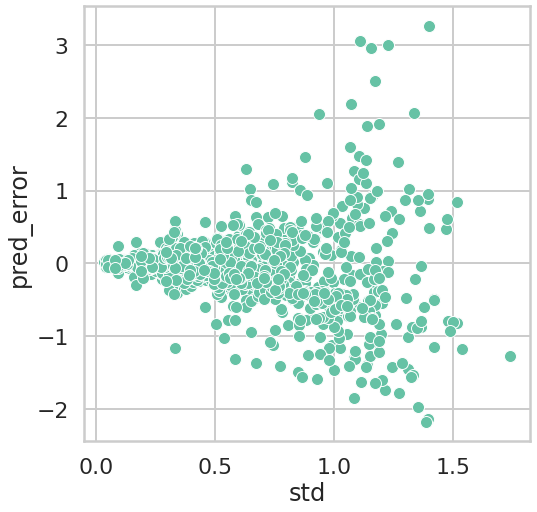

In [33]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=pred_df, x="std", y="pred_error", ax=ax)

### Grid search
#### Tunable parameters for Random Forest models
- rf_estimators: number of estimators to use in random forest models
- rf_max_depth: the maximum depth of a decision tree in the random forest
- rf_max_features: max number of features to split random forest nodes

## Time for running the following code chunk: ~ 10 minutes on COLAB-Pro

In [34]:
# param_choice = [16,32,64,128]
param_choice = [16, 32, 64]

rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in param_choice:
    for rf_depth in param_choice:
        for rf_feature in param_choice:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

2021-08-11 00:25:48,034 Attempting to load featurized dataset
2021-08-11 00:25:48,042 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:25:48,042 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:25:48,053 Featurizing sample 0
2021-08-11 00:25:53,929 Featurizing sample 1000
2021-08-11 00:25:56,089 Previous dataset split restored
2021-08-11 00:25:56,103 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/42423b27-c02f-4599-8201-667aaf76e878/transformers.pkl
2021-08-11 00:25:56,108 Transforming response data
2021-08-11 00:25:56,134 Transforming response data
2021-08-11 00:25:56,148 Transforming response data
2021-08-11 00:25:56,173 Fitting random forest model


number of features: 1024


2021-08-11 00:25:56,616 Fold 0: training r2_score = 0.865, validation r2_score = 0.396, test r2_score = 0.431
2021-08-11 00:25:56,641 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/42423b27-c02f-4599-8201-667aaf76e878/model_metadata.json
2021-08-11 00:25:56,655 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/42423b27-c02f-4599-8201-667aaf76e878/model_metrics.json
2021-08-11 00:25:56,666 Attempting to load featurized dataset
2021-08-11 00:25:56,677 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:25:56,678 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:25:56,694 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_42423b27-c02f-4599-8201-667aaf76e878.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3960169267773953


2021-08-11 00:26:02,583 Featurizing sample 1000
2021-08-11 00:26:04,774 Previous dataset split restored
2021-08-11 00:26:04,791 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/94e3b319-ed32-414a-ae75-2a4eec516f00/transformers.pkl
2021-08-11 00:26:04,792 Transforming response data
2021-08-11 00:26:04,813 Transforming response data
2021-08-11 00:26:04,825 Transforming response data
2021-08-11 00:26:04,849 Fitting random forest model


number of features: 1024


2021-08-11 00:26:05,288 Fold 0: training r2_score = 0.899, validation r2_score = 0.351, test r2_score = 0.502
2021-08-11 00:26:05,314 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/94e3b319-ed32-414a-ae75-2a4eec516f00/model_metadata.json
2021-08-11 00:26:05,327 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/94e3b319-ed32-414a-ae75-2a4eec516f00/model_metrics.json
2021-08-11 00:26:05,339 Attempting to load featurized dataset
2021-08-11 00:26:05,347 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:26:05,348 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:26:05,365 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_94e3b319-ed32-414a-ae75-2a4eec516f00.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3505295881284278


2021-08-11 00:26:11,154 Featurizing sample 1000
2021-08-11 00:26:13,335 Previous dataset split restored
2021-08-11 00:26:13,350 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/46712b63-74e7-4ed3-a5ed-a3df44be894b/transformers.pkl
2021-08-11 00:26:13,352 Transforming response data
2021-08-11 00:26:13,373 Transforming response data
2021-08-11 00:26:13,384 Transforming response data
2021-08-11 00:26:13,407 Fitting random forest model


number of features: 1024


2021-08-11 00:26:13,847 Fold 0: training r2_score = 0.915, validation r2_score = 0.460, test r2_score = 0.520
2021-08-11 00:26:13,872 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/46712b63-74e7-4ed3-a5ed-a3df44be894b/model_metadata.json
2021-08-11 00:26:13,886 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/46712b63-74e7-4ed3-a5ed-a3df44be894b/model_metrics.json
2021-08-11 00:26:13,899 Attempting to load featurized dataset
2021-08-11 00:26:13,908 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:26:13,913 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:26:13,924 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_46712b63-74e7-4ed3-a5ed-a3df44be894b.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.4600073638861877


2021-08-11 00:26:19,764 Featurizing sample 1000
2021-08-11 00:26:21,935 Previous dataset split restored
2021-08-11 00:26:21,948 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/00256720-f5f3-4ddb-a9b5-5e29adfed532/transformers.pkl
2021-08-11 00:26:21,950 Transforming response data
2021-08-11 00:26:21,976 Transforming response data
2021-08-11 00:26:21,988 Transforming response data
2021-08-11 00:26:22,015 Fitting random forest model


number of features: 1024


2021-08-11 00:26:22,453 Fold 0: training r2_score = 0.950, validation r2_score = 0.391, test r2_score = 0.501
2021-08-11 00:26:22,486 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/00256720-f5f3-4ddb-a9b5-5e29adfed532/model_metadata.json
2021-08-11 00:26:22,504 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/00256720-f5f3-4ddb-a9b5-5e29adfed532/model_metrics.json
2021-08-11 00:26:22,517 Attempting to load featurized dataset
2021-08-11 00:26:22,525 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:26:22,526 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:26:22,537 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_00256720-f5f3-4ddb-a9b5-5e29adfed532.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.390933442289513


2021-08-11 00:26:28,551 Featurizing sample 1000
2021-08-11 00:26:30,929 Previous dataset split restored
2021-08-11 00:26:30,945 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3f849e99-8168-45c2-bb1a-8782ffd14491/transformers.pkl
2021-08-11 00:26:30,946 Transforming response data
2021-08-11 00:26:30,969 Transforming response data
2021-08-11 00:26:30,983 Transforming response data
2021-08-11 00:26:31,010 Fitting random forest model


number of features: 1024


2021-08-11 00:26:31,453 Fold 0: training r2_score = 0.953, validation r2_score = 0.439, test r2_score = 0.508
2021-08-11 00:26:31,506 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3f849e99-8168-45c2-bb1a-8782ffd14491/model_metadata.json
2021-08-11 00:26:31,530 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3f849e99-8168-45c2-bb1a-8782ffd14491/model_metrics.json
2021-08-11 00:26:31,544 Attempting to load featurized dataset
2021-08-11 00:26:31,553 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:26:31,554 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:26:31,567 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_3f849e99-8168-45c2-bb1a-8782ffd14491.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4391800346215625


2021-08-11 00:26:37,679 Featurizing sample 1000
2021-08-11 00:26:39,992 Previous dataset split restored
2021-08-11 00:26:40,013 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8a1a51e0-991e-479c-8785-86ad999a9296/transformers.pkl
2021-08-11 00:26:40,014 Transforming response data
2021-08-11 00:26:40,041 Transforming response data
2021-08-11 00:26:40,055 Transforming response data
2021-08-11 00:26:40,079 Fitting random forest model


number of features: 1024


2021-08-11 00:26:40,625 Fold 0: training r2_score = 0.959, validation r2_score = 0.422, test r2_score = 0.458
2021-08-11 00:26:40,663 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8a1a51e0-991e-479c-8785-86ad999a9296/model_metadata.json
2021-08-11 00:26:40,686 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8a1a51e0-991e-479c-8785-86ad999a9296/model_metrics.json
2021-08-11 00:26:40,700 Attempting to load featurized dataset
2021-08-11 00:26:40,709 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:26:40,710 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:26:40,722 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_8a1a51e0-991e-479c-8785-86ad999a9296.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.42175707291938436


2021-08-11 00:26:46,939 Featurizing sample 1000
2021-08-11 00:26:49,275 Previous dataset split restored
2021-08-11 00:26:49,288 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/4c5ba442-74c6-48df-b65f-7c0bd33513b7/transformers.pkl
2021-08-11 00:26:49,292 Transforming response data
2021-08-11 00:26:49,316 Transforming response data
2021-08-11 00:26:49,329 Transforming response data
2021-08-11 00:26:49,353 Fitting random forest model


number of features: 1024


2021-08-11 00:26:49,793 Fold 0: training r2_score = 0.955, validation r2_score = 0.352, test r2_score = 0.500
2021-08-11 00:26:49,827 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4c5ba442-74c6-48df-b65f-7c0bd33513b7/model_metadata.json
2021-08-11 00:26:49,849 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4c5ba442-74c6-48df-b65f-7c0bd33513b7/model_metrics.json
2021-08-11 00:26:49,862 Attempting to load featurized dataset
2021-08-11 00:26:49,870 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:26:49,871 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:26:49,883 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_4c5ba442-74c6-48df-b65f-7c0bd33513b7.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.35199459851153847


2021-08-11 00:26:55,632 Featurizing sample 1000
2021-08-11 00:26:57,765 Previous dataset split restored
2021-08-11 00:26:57,779 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/edf86519-d412-48c0-9eb4-ecb20afb0379/transformers.pkl
2021-08-11 00:26:57,781 Transforming response data
2021-08-11 00:26:57,807 Transforming response data
2021-08-11 00:26:57,820 Transforming response data
2021-08-11 00:26:57,847 Fitting random forest model


number of features: 1024


2021-08-11 00:26:58,288 Fold 0: training r2_score = 0.956, validation r2_score = 0.422, test r2_score = 0.482
2021-08-11 00:26:58,325 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/edf86519-d412-48c0-9eb4-ecb20afb0379/model_metadata.json
2021-08-11 00:26:58,346 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/edf86519-d412-48c0-9eb4-ecb20afb0379/model_metrics.json
2021-08-11 00:26:58,360 Attempting to load featurized dataset
2021-08-11 00:26:58,369 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:26:58,369 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:26:58,381 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_edf86519-d412-48c0-9eb4-ecb20afb0379.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.4222441123695051


2021-08-11 00:27:04,520 Featurizing sample 1000
2021-08-11 00:27:06,835 Previous dataset split restored
2021-08-11 00:27:06,849 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3cb4a88e-bca1-4fdf-aba6-38c3d5814c00/transformers.pkl
2021-08-11 00:27:06,851 Transforming response data
2021-08-11 00:27:06,876 Transforming response data
2021-08-11 00:27:06,889 Transforming response data
2021-08-11 00:27:06,915 Fitting random forest model


number of features: 1024


2021-08-11 00:27:07,461 Fold 0: training r2_score = 0.957, validation r2_score = 0.375, test r2_score = 0.498
2021-08-11 00:27:07,496 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3cb4a88e-bca1-4fdf-aba6-38c3d5814c00/model_metadata.json
2021-08-11 00:27:07,520 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3cb4a88e-bca1-4fdf-aba6-38c3d5814c00/model_metrics.json
2021-08-11 00:27:07,536 Attempting to load featurized dataset
2021-08-11 00:27:07,546 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:27:07,547 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:27:07,569 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_3cb4a88e-bca1-4fdf-aba6-38c3d5814c00.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.3749356127735296


2021-08-11 00:27:13,925 Featurizing sample 1000
2021-08-11 00:27:16,222 Previous dataset split restored
2021-08-11 00:27:16,236 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/700f107c-0931-47f9-8c3e-27e19ead6c13/transformers.pkl
2021-08-11 00:27:16,238 Transforming response data
2021-08-11 00:27:16,260 Transforming response data
2021-08-11 00:27:16,277 Transforming response data
2021-08-11 00:27:16,304 Fitting random forest model


number of features: 1024


2021-08-11 00:27:16,750 Fold 0: training r2_score = 0.876, validation r2_score = 0.397, test r2_score = 0.450
2021-08-11 00:27:16,797 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/700f107c-0931-47f9-8c3e-27e19ead6c13/model_metadata.json
2021-08-11 00:27:16,822 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/700f107c-0931-47f9-8c3e-27e19ead6c13/model_metrics.json
2021-08-11 00:27:16,834 Attempting to load featurized dataset
2021-08-11 00:27:16,843 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:27:16,845 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:27:16,857 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_700f107c-0931-47f9-8c3e-27e19ead6c13.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.39667846849909705


2021-08-11 00:27:23,041 Featurizing sample 1000
2021-08-11 00:27:25,216 Previous dataset split restored
2021-08-11 00:27:25,230 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/15bc7195-5130-4bca-870b-fc958caed5f2/transformers.pkl
2021-08-11 00:27:25,234 Transforming response data
2021-08-11 00:27:25,255 Transforming response data
2021-08-11 00:27:25,266 Transforming response data
2021-08-11 00:27:25,291 Fitting random forest model


number of features: 1024


2021-08-11 00:27:25,836 Fold 0: training r2_score = 0.903, validation r2_score = 0.393, test r2_score = 0.488
2021-08-11 00:27:25,883 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/15bc7195-5130-4bca-870b-fc958caed5f2/model_metadata.json
2021-08-11 00:27:25,905 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/15bc7195-5130-4bca-870b-fc958caed5f2/model_metrics.json
2021-08-11 00:27:25,918 Attempting to load featurized dataset
2021-08-11 00:27:25,927 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:27:25,928 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:27:25,941 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_15bc7195-5130-4bca-870b-fc958caed5f2.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3927811986768648


2021-08-11 00:27:31,894 Featurizing sample 1000
2021-08-11 00:27:34,086 Previous dataset split restored
2021-08-11 00:27:34,099 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/6eb0402b-cc69-47a5-8afe-247a6e41b308/transformers.pkl
2021-08-11 00:27:34,105 Transforming response data
2021-08-11 00:27:34,126 Transforming response data
2021-08-11 00:27:34,139 Transforming response data
2021-08-11 00:27:34,164 Fitting random forest model


number of features: 1024


2021-08-11 00:27:34,709 Fold 0: training r2_score = 0.922, validation r2_score = 0.448, test r2_score = 0.527
2021-08-11 00:27:34,754 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/6eb0402b-cc69-47a5-8afe-247a6e41b308/model_metadata.json
2021-08-11 00:27:34,778 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/6eb0402b-cc69-47a5-8afe-247a6e41b308/model_metrics.json
2021-08-11 00:27:34,791 Attempting to load featurized dataset
2021-08-11 00:27:34,800 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:27:34,801 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:27:34,813 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_6eb0402b-cc69-47a5-8afe-247a6e41b308.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.4480686493700571


2021-08-11 00:27:40,595 Featurizing sample 1000
2021-08-11 00:27:42,766 Previous dataset split restored
2021-08-11 00:27:42,782 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/38ee816c-b04c-43ec-9d0a-15edee617a33/transformers.pkl
2021-08-11 00:27:42,784 Transforming response data
2021-08-11 00:27:42,806 Transforming response data
2021-08-11 00:27:42,818 Transforming response data
2021-08-11 00:27:42,842 Fitting random forest model


number of features: 1024


2021-08-11 00:27:43,387 Fold 0: training r2_score = 0.959, validation r2_score = 0.426, test r2_score = 0.486
2021-08-11 00:27:43,451 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/38ee816c-b04c-43ec-9d0a-15edee617a33/model_metadata.json
2021-08-11 00:27:43,483 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/38ee816c-b04c-43ec-9d0a-15edee617a33/model_metrics.json
2021-08-11 00:27:43,495 Attempting to load featurized dataset
2021-08-11 00:27:43,504 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:27:43,507 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:27:43,520 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_38ee816c-b04c-43ec-9d0a-15edee617a33.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.4262498577011963


2021-08-11 00:27:49,311 Featurizing sample 1000
2021-08-11 00:27:51,469 Previous dataset split restored
2021-08-11 00:27:51,483 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/10cb88ea-707b-457a-98bc-e75d80866126/transformers.pkl
2021-08-11 00:27:51,487 Transforming response data
2021-08-11 00:27:51,515 Transforming response data
2021-08-11 00:27:51,527 Transforming response data
2021-08-11 00:27:51,551 Fitting random forest model


number of features: 1024


2021-08-11 00:27:52,101 Fold 0: training r2_score = 0.960, validation r2_score = 0.433, test r2_score = 0.480
2021-08-11 00:27:52,161 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/10cb88ea-707b-457a-98bc-e75d80866126/model_metadata.json
2021-08-11 00:27:52,194 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/10cb88ea-707b-457a-98bc-e75d80866126/model_metrics.json
2021-08-11 00:27:52,212 Attempting to load featurized dataset
2021-08-11 00:27:52,220 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:27:52,227 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:27:52,240 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_10cb88ea-707b-457a-98bc-e75d80866126.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.43324663147638043


2021-08-11 00:27:58,121 Featurizing sample 1000
2021-08-11 00:28:00,277 Previous dataset split restored
2021-08-11 00:28:00,293 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b902babc-d7f7-4bfa-8ff9-431c82533d74/transformers.pkl
2021-08-11 00:28:00,294 Transforming response data
2021-08-11 00:28:00,317 Transforming response data
2021-08-11 00:28:00,330 Transforming response data
2021-08-11 00:28:00,355 Fitting random forest model


number of features: 1024


2021-08-11 00:28:00,901 Fold 0: training r2_score = 0.961, validation r2_score = 0.421, test r2_score = 0.475
2021-08-11 00:28:00,960 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b902babc-d7f7-4bfa-8ff9-431c82533d74/model_metadata.json
2021-08-11 00:28:00,993 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b902babc-d7f7-4bfa-8ff9-431c82533d74/model_metrics.json
2021-08-11 00:28:01,006 Attempting to load featurized dataset
2021-08-11 00:28:01,014 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:28:01,015 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:28:01,030 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_b902babc-d7f7-4bfa-8ff9-431c82533d74.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.42073470264383217


2021-08-11 00:28:07,097 Featurizing sample 1000
2021-08-11 00:28:09,408 Previous dataset split restored
2021-08-11 00:28:09,428 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ed172771-06f2-4ddf-912f-0c8993104a7f/transformers.pkl
2021-08-11 00:28:09,429 Transforming response data
2021-08-11 00:28:09,455 Transforming response data
2021-08-11 00:28:09,466 Transforming response data
2021-08-11 00:28:09,492 Fitting random forest model


number of features: 1024


2021-08-11 00:28:10,041 Fold 0: training r2_score = 0.961, validation r2_score = 0.399, test r2_score = 0.530
2021-08-11 00:28:10,113 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ed172771-06f2-4ddf-912f-0c8993104a7f/model_metadata.json
2021-08-11 00:28:10,150 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ed172771-06f2-4ddf-912f-0c8993104a7f/model_metrics.json
2021-08-11 00:28:10,170 Attempting to load featurized dataset
2021-08-11 00:28:10,181 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:28:10,182 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:28:10,196 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_ed172771-06f2-4ddf-912f-0c8993104a7f.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.3988567012433485


2021-08-11 00:28:16,397 Featurizing sample 1000
2021-08-11 00:28:18,721 Previous dataset split restored
2021-08-11 00:28:18,739 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/62de773f-b0f4-4144-a4b0-606715567cac/transformers.pkl
2021-08-11 00:28:18,740 Transforming response data
2021-08-11 00:28:18,765 Transforming response data
2021-08-11 00:28:18,779 Transforming response data
2021-08-11 00:28:18,806 Fitting random forest model


number of features: 1024


2021-08-11 00:28:19,358 Fold 0: training r2_score = 0.961, validation r2_score = 0.436, test r2_score = 0.528
2021-08-11 00:28:19,427 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/62de773f-b0f4-4144-a4b0-606715567cac/model_metadata.json
2021-08-11 00:28:19,462 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/62de773f-b0f4-4144-a4b0-606715567cac/model_metrics.json
2021-08-11 00:28:19,477 Attempting to load featurized dataset
2021-08-11 00:28:19,487 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:28:19,488 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:28:19,503 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_62de773f-b0f4-4144-a4b0-606715567cac.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.43641026586067666


2021-08-11 00:28:25,948 Featurizing sample 1000
2021-08-11 00:28:28,270 Previous dataset split restored
2021-08-11 00:28:28,286 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/21ac77b2-29b3-43a4-8bdc-38cadfbfa7fc/transformers.pkl
2021-08-11 00:28:28,288 Transforming response data
2021-08-11 00:28:28,313 Transforming response data
2021-08-11 00:28:28,325 Transforming response data
2021-08-11 00:28:28,353 Fitting random forest model


number of features: 1024


2021-08-11 00:28:29,004 Fold 0: training r2_score = 0.965, validation r2_score = 0.468, test r2_score = 0.532
2021-08-11 00:28:29,075 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/21ac77b2-29b3-43a4-8bdc-38cadfbfa7fc/model_metadata.json
2021-08-11 00:28:29,110 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/21ac77b2-29b3-43a4-8bdc-38cadfbfa7fc/model_metrics.json
2021-08-11 00:28:29,128 Attempting to load featurized dataset
2021-08-11 00:28:29,139 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:28:29,140 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:28:29,156 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_21ac77b2-29b3-43a4-8bdc-38cadfbfa7fc.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.46793790088782805


2021-08-11 00:28:34,929 Featurizing sample 1000
2021-08-11 00:28:37,065 Previous dataset split restored
2021-08-11 00:28:37,080 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/62ac85ea-9ba3-4953-bad5-10960f1d9c32/transformers.pkl
2021-08-11 00:28:37,082 Transforming response data
2021-08-11 00:28:37,107 Transforming response data
2021-08-11 00:28:37,118 Transforming response data
2021-08-11 00:28:37,145 Fitting random forest model


number of features: 1024


2021-08-11 00:28:37,807 Fold 0: training r2_score = 0.878, validation r2_score = 0.348, test r2_score = 0.447
2021-08-11 00:28:37,890 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/62ac85ea-9ba3-4953-bad5-10960f1d9c32/model_metadata.json
2021-08-11 00:28:37,930 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/62ac85ea-9ba3-4953-bad5-10960f1d9c32/model_metrics.json
2021-08-11 00:28:37,944 Attempting to load featurized dataset
2021-08-11 00:28:37,953 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:28:37,954 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:28:37,966 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_62ac85ea-9ba3-4953-bad5-10960f1d9c32.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.34791149503882035


2021-08-11 00:28:43,832 Featurizing sample 1000
2021-08-11 00:28:46,065 Previous dataset split restored
2021-08-11 00:28:46,079 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/05e92b0b-fc84-4e80-8e91-575e35364126/transformers.pkl
2021-08-11 00:28:46,082 Transforming response data
2021-08-11 00:28:46,105 Transforming response data
2021-08-11 00:28:46,117 Transforming response data
2021-08-11 00:28:46,142 Fitting random forest model


number of features: 1024


2021-08-11 00:28:46,803 Fold 0: training r2_score = 0.908, validation r2_score = 0.402, test r2_score = 0.479
2021-08-11 00:28:46,881 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/05e92b0b-fc84-4e80-8e91-575e35364126/model_metadata.json
2021-08-11 00:28:46,926 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/05e92b0b-fc84-4e80-8e91-575e35364126/model_metrics.json
2021-08-11 00:28:46,939 Attempting to load featurized dataset
2021-08-11 00:28:46,949 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:28:46,950 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:28:46,961 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_05e92b0b-fc84-4e80-8e91-575e35364126.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.4019794255947188


2021-08-11 00:28:52,727 Featurizing sample 1000
2021-08-11 00:28:54,922 Previous dataset split restored
2021-08-11 00:28:54,936 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/98513d42-f599-4312-9b4f-bd336e0213e0/transformers.pkl
2021-08-11 00:28:54,940 Transforming response data
2021-08-11 00:28:54,962 Transforming response data
2021-08-11 00:28:54,975 Transforming response data
2021-08-11 00:28:54,999 Fitting random forest model


number of features: 1024


2021-08-11 00:28:55,763 Fold 0: training r2_score = 0.923, validation r2_score = 0.429, test r2_score = 0.529
2021-08-11 00:28:55,854 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/98513d42-f599-4312-9b4f-bd336e0213e0/model_metadata.json
2021-08-11 00:28:55,895 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/98513d42-f599-4312-9b4f-bd336e0213e0/model_metrics.json
2021-08-11 00:28:55,909 Attempting to load featurized dataset
2021-08-11 00:28:55,917 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:28:55,918 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:28:55,931 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_98513d42-f599-4312-9b4f-bd336e0213e0.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.429235118555676


2021-08-11 00:29:01,771 Featurizing sample 1000
2021-08-11 00:29:03,996 Previous dataset split restored
2021-08-11 00:29:04,009 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ae415d5e-d41d-4ad3-98b2-33157acded81/transformers.pkl
2021-08-11 00:29:04,013 Transforming response data
2021-08-11 00:29:04,036 Transforming response data
2021-08-11 00:29:04,048 Transforming response data
2021-08-11 00:29:04,074 Fitting random forest model


number of features: 1024


2021-08-11 00:29:04,731 Fold 0: training r2_score = 0.960, validation r2_score = 0.423, test r2_score = 0.502
2021-08-11 00:29:04,840 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ae415d5e-d41d-4ad3-98b2-33157acded81/model_metadata.json
2021-08-11 00:29:04,899 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ae415d5e-d41d-4ad3-98b2-33157acded81/model_metrics.json
2021-08-11 00:29:04,913 Attempting to load featurized dataset
2021-08-11 00:29:04,923 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:29:04,924 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:29:04,936 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_ae415d5e-d41d-4ad3-98b2-33157acded81.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.4230715585256083


2021-08-11 00:29:10,670 Featurizing sample 1000
2021-08-11 00:29:12,976 Previous dataset split restored
2021-08-11 00:29:13,000 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/65a09413-bb70-4a85-bc2c-c6339306e8f0/transformers.pkl
2021-08-11 00:29:13,004 Transforming response data
2021-08-11 00:29:13,030 Transforming response data
2021-08-11 00:29:13,044 Transforming response data
2021-08-11 00:29:13,071 Fitting random forest model


number of features: 1024


2021-08-11 00:29:13,841 Fold 0: training r2_score = 0.962, validation r2_score = 0.433, test r2_score = 0.510
2021-08-11 00:29:13,978 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/65a09413-bb70-4a85-bc2c-c6339306e8f0/model_metadata.json
2021-08-11 00:29:14,046 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/65a09413-bb70-4a85-bc2c-c6339306e8f0/model_metrics.json
2021-08-11 00:29:14,062 Attempting to load featurized dataset
2021-08-11 00:29:14,071 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:29:14,073 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:29:14,088 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_65a09413-bb70-4a85-bc2c-c6339306e8f0.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4325768493441816


2021-08-11 00:29:20,274 Featurizing sample 1000
2021-08-11 00:29:22,563 Previous dataset split restored
2021-08-11 00:29:22,582 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/64d34409-2280-4251-a81f-c2bbd19b71cb/transformers.pkl
2021-08-11 00:29:22,584 Transforming response data
2021-08-11 00:29:22,618 Transforming response data
2021-08-11 00:29:22,631 Transforming response data
2021-08-11 00:29:22,659 Fitting random forest model


number of features: 1024


2021-08-11 00:29:23,530 Fold 0: training r2_score = 0.963, validation r2_score = 0.437, test r2_score = 0.533
2021-08-11 00:29:23,658 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/64d34409-2280-4251-a81f-c2bbd19b71cb/model_metadata.json
2021-08-11 00:29:23,721 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/64d34409-2280-4251-a81f-c2bbd19b71cb/model_metrics.json
2021-08-11 00:29:23,737 Attempting to load featurized dataset
2021-08-11 00:29:23,746 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:29:23,747 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:29:23,760 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_64d34409-2280-4251-a81f-c2bbd19b71cb.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.4371304243058133


2021-08-11 00:29:30,032 Featurizing sample 1000
2021-08-11 00:29:32,363 Previous dataset split restored
2021-08-11 00:29:32,380 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/7de499d7-80d4-44ae-8ed4-a3a7f54469cb/transformers.pkl
2021-08-11 00:29:32,381 Transforming response data
2021-08-11 00:29:32,406 Transforming response data
2021-08-11 00:29:32,419 Transforming response data
2021-08-11 00:29:32,448 Fitting random forest model


number of features: 1024


2021-08-11 00:29:33,114 Fold 0: training r2_score = 0.963, validation r2_score = 0.422, test r2_score = 0.526
2021-08-11 00:29:33,245 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7de499d7-80d4-44ae-8ed4-a3a7f54469cb/model_metadata.json
2021-08-11 00:29:33,319 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7de499d7-80d4-44ae-8ed4-a3a7f54469cb/model_metrics.json
2021-08-11 00:29:33,333 Attempting to load featurized dataset
2021-08-11 00:29:33,341 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:29:33,342 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:29:33,358 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_7de499d7-80d4-44ae-8ed4-a3a7f54469cb.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.42164000670865054


2021-08-11 00:29:39,282 Featurizing sample 1000
2021-08-11 00:29:41,419 Previous dataset split restored
2021-08-11 00:29:41,437 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9ad6a727-ec7d-404d-96bc-7d581bdff598/transformers.pkl
2021-08-11 00:29:41,438 Transforming response data
2021-08-11 00:29:41,462 Transforming response data
2021-08-11 00:29:41,475 Transforming response data
2021-08-11 00:29:41,499 Fitting random forest model


number of features: 1024


2021-08-11 00:29:42,259 Fold 0: training r2_score = 0.964, validation r2_score = 0.445, test r2_score = 0.523
2021-08-11 00:29:42,372 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9ad6a727-ec7d-404d-96bc-7d581bdff598/model_metadata.json
2021-08-11 00:29:42,438 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9ad6a727-ec7d-404d-96bc-7d581bdff598/model_metrics.json
2021-08-11 00:29:42,451 Attempting to load featurized dataset
2021-08-11 00:29:42,459 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:29:42,462 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:29:42,475 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_9ad6a727-ec7d-404d-96bc-7d581bdff598.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.4449688806778509


2021-08-11 00:29:48,245 Featurizing sample 1000
2021-08-11 00:29:50,396 Previous dataset split restored
2021-08-11 00:29:50,409 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/0a38c2c1-1b10-4de6-9951-41f9e085cb24/transformers.pkl
2021-08-11 00:29:50,414 Transforming response data
2021-08-11 00:29:50,438 Transforming response data
2021-08-11 00:29:50,449 Transforming response data
2021-08-11 00:29:50,475 Fitting random forest model


number of features: 1024


2021-08-11 00:29:51,234 Fold 0: training r2_score = 0.964, validation r2_score = 0.436, test r2_score = 0.529
2021-08-11 00:29:51,348 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0a38c2c1-1b10-4de6-9951-41f9e085cb24/model_metadata.json
2021-08-11 00:29:51,413 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0a38c2c1-1b10-4de6-9951-41f9e085cb24/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_0a38c2c1-1b10-4de6-9951-41f9e085cb24.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4359956045728688


# You will see output such as shown below:

```
2021-05-20 23:40:21,639 Previous dataset split restored
number of features: 1024
2021-05-20 23:40:22,145 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d14c9db0-5aec-4326-8b66-ebd60454786b/model_metadata.json
2021-05-20 23:40:22,159 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d14c9db0-5aec-4326-8b66-ebd60454786b/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_d14c9db0-5aec-4326-8b66-ebd60454786b.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3960169267773953
......
.......

2021-05-20 23:48:22,091 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1010b739-7736-4505-99c4-ba50b33d90df/model_metadata.json
2021-05-20 23:48:22,193 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1010b739-7736-4505-99c4-ba50b33d90df/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_1010b739-7736-4505-99c4-ba50b33d90df.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4739461661466364

```



In [35]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
17,32,64,64,0.467938
2,16,16,64,0.460007
11,32,16,64,0.448069
25,64,64,32,0.444969
4,16,32,32,0.439180
23,64,32,64,0.437130
16,32,64,32,0.436410
26,64,64,64,0.435996
13,32,32,32,0.433247
22,64,32,32,0.432577


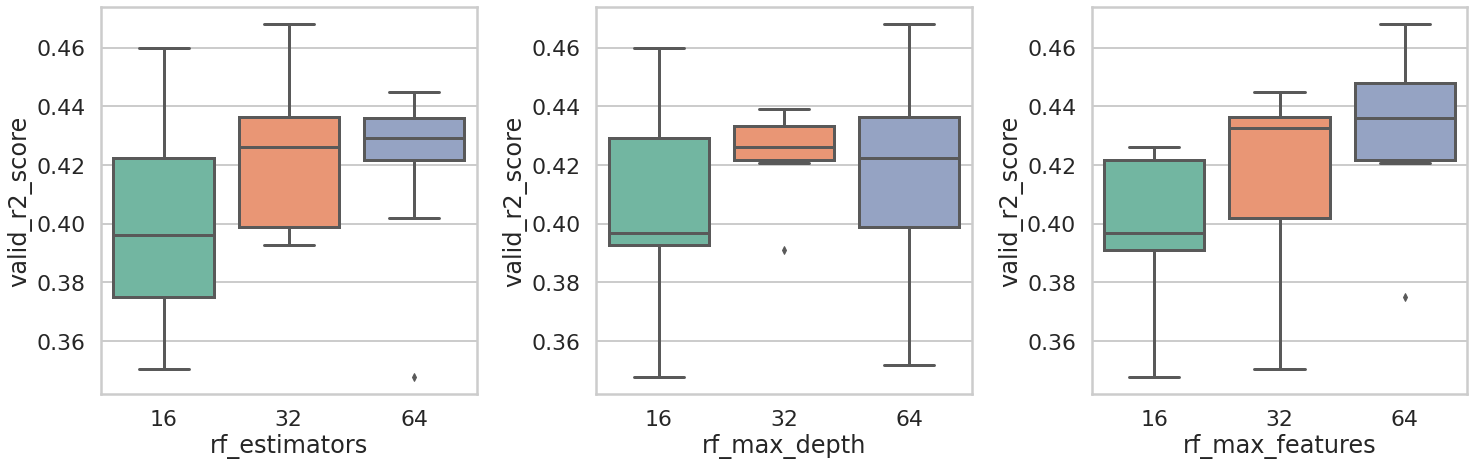

In [36]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

## Time for running the following code chunk: ~ 10 minutes on COLAB-Pro

### Random search

In [37]:
rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []

num_trials = 50

for i in range(num_trials):
    params["rf_estimators"] = np.random.randint(8,256)
    params["rf_max_depth"] = np.random.randint(8,256)
    params["rf_max_features"] = np.random.randint(8,256)
    rfe_list.append(params["rf_estimators"])
    rfd_list.append(params["rf_max_depth"])
    rff_list.append(params["rf_max_features"])
    tp = parse.wrapper(params)
    pl = mp.ModelPipeline(tp)
    pl.train_model()
    pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = pred_data.get_prediction_results()
    valid_r2 = pred_results['r2_score']
    valid_r2_list.append(valid_r2)
    print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

2021-08-11 00:29:52,175 Attempting to load featurized dataset
2021-08-11 00:29:52,183 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:29:52,184 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:29:52,195 Featurizing sample 0
2021-08-11 00:29:57,985 Featurizing sample 1000
2021-08-11 00:30:00,128 Previous dataset split restored
2021-08-11 00:30:00,142 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/398d34a4-4e98-4563-b4e9-9e82255a2a35/transformers.pkl
2021-08-11 00:30:00,144 Transforming response data
2021-08-11 00:30:00,165 Transforming response data
2021-08-11 00:30:00,176 Transforming response data
2021-08-11 00:30:00,200 Fitting random forest model


number of features: 1024


2021-08-11 00:30:01,477 Fold 0: training r2_score = 0.966, validation r2_score = 0.459, test r2_score = 0.539
2021-08-11 00:30:01,666 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/398d34a4-4e98-4563-b4e9-9e82255a2a35/model_metadata.json
2021-08-11 00:30:01,769 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/398d34a4-4e98-4563-b4e9-9e82255a2a35/model_metrics.json
2021-08-11 00:30:01,782 Attempting to load featurized dataset
2021-08-11 00:30:01,796 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:30:01,797 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:30:01,811 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_398d34a4-4e98-4563-b4e9-9e82255a2a35.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45875868345740045


2021-08-11 00:30:07,621 Featurizing sample 1000
2021-08-11 00:30:09,736 Previous dataset split restored
2021-08-11 00:30:09,749 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/80065296-f65c-4f64-a1ff-bb26563ba9a9/transformers.pkl
2021-08-11 00:30:09,755 Transforming response data
2021-08-11 00:30:09,778 Transforming response data
2021-08-11 00:30:09,790 Transforming response data
2021-08-11 00:30:09,817 Fitting random forest model


number of features: 1024


2021-08-11 00:30:11,398 Fold 0: training r2_score = 0.966, validation r2_score = 0.438, test r2_score = 0.531
2021-08-11 00:30:11,624 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/80065296-f65c-4f64-a1ff-bb26563ba9a9/model_metadata.json
2021-08-11 00:30:11,729 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/80065296-f65c-4f64-a1ff-bb26563ba9a9/model_metrics.json
2021-08-11 00:30:11,744 Attempting to load featurized dataset
2021-08-11 00:30:11,753 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:30:11,754 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:30:11,765 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_80065296-f65c-4f64-a1ff-bb26563ba9a9.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.43762827525482706


2021-08-11 00:30:17,579 Featurizing sample 1000
2021-08-11 00:30:19,867 Previous dataset split restored
2021-08-11 00:30:19,881 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/6fcc1447-4b34-48f4-a81d-2ddaab2a5fdf/transformers.pkl
2021-08-11 00:30:19,885 Transforming response data
2021-08-11 00:30:19,908 Transforming response data
2021-08-11 00:30:19,923 Transforming response data
2021-08-11 00:30:19,958 Fitting random forest model


number of features: 1024


2021-08-11 00:30:21,741 Fold 0: training r2_score = 0.966, validation r2_score = 0.464, test r2_score = 0.511
2021-08-11 00:30:21,948 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/6fcc1447-4b34-48f4-a81d-2ddaab2a5fdf/model_metadata.json
2021-08-11 00:30:22,069 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/6fcc1447-4b34-48f4-a81d-2ddaab2a5fdf/model_metrics.json
2021-08-11 00:30:22,083 Attempting to load featurized dataset
2021-08-11 00:30:22,091 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:30:22,092 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:30:22,104 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_6fcc1447-4b34-48f4-a81d-2ddaab2a5fdf.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.46441668064531505


2021-08-11 00:30:28,357 Featurizing sample 1000
2021-08-11 00:30:30,637 Previous dataset split restored
2021-08-11 00:30:30,651 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/fdab4c27-8ee0-4e44-b774-2756ff28ffcf/transformers.pkl
2021-08-11 00:30:30,654 Transforming response data
2021-08-11 00:30:30,675 Transforming response data
2021-08-11 00:30:30,687 Transforming response data
2021-08-11 00:30:30,715 Fitting random forest model


number of features: 1024


2021-08-11 00:30:33,250 Fold 0: training r2_score = 0.966, validation r2_score = 0.454, test r2_score = 0.549
2021-08-11 00:30:33,700 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/fdab4c27-8ee0-4e44-b774-2756ff28ffcf/model_metadata.json
2021-08-11 00:30:33,941 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/fdab4c27-8ee0-4e44-b774-2756ff28ffcf/model_metrics.json
2021-08-11 00:30:33,957 Attempting to load featurized dataset
2021-08-11 00:30:33,965 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:30:33,966 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:30:33,979 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_fdab4c27-8ee0-4e44-b774-2756ff28ffcf.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45441029873539696


2021-08-11 00:30:40,099 Featurizing sample 1000
2021-08-11 00:30:42,393 Previous dataset split restored
2021-08-11 00:30:42,407 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a9da61da-3d98-4a4c-bb22-87d598d1e152/transformers.pkl
2021-08-11 00:30:42,411 Transforming response data
2021-08-11 00:30:42,433 Transforming response data
2021-08-11 00:30:42,445 Transforming response data
2021-08-11 00:30:42,471 Fitting random forest model


number of features: 1024


2021-08-11 00:30:43,656 Fold 0: training r2_score = 0.964, validation r2_score = 0.440, test r2_score = 0.540
2021-08-11 00:30:43,899 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a9da61da-3d98-4a4c-bb22-87d598d1e152/model_metadata.json
2021-08-11 00:30:44,006 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a9da61da-3d98-4a4c-bb22-87d598d1e152/model_metrics.json
2021-08-11 00:30:44,020 Attempting to load featurized dataset
2021-08-11 00:30:44,028 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:30:44,029 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:30:44,042 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_a9da61da-3d98-4a4c-bb22-87d598d1e152.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.43956170904649194


2021-08-11 00:30:49,897 Featurizing sample 1000
2021-08-11 00:30:52,128 Previous dataset split restored
2021-08-11 00:30:52,145 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/78b49afb-3761-41d8-9de2-b7711fbfd413/transformers.pkl
2021-08-11 00:30:52,147 Transforming response data
2021-08-11 00:30:52,168 Transforming response data
2021-08-11 00:30:52,180 Transforming response data
2021-08-11 00:30:52,205 Fitting random forest model


number of features: 1024


2021-08-11 00:30:54,358 Fold 0: training r2_score = 0.966, validation r2_score = 0.469, test r2_score = 0.530
2021-08-11 00:30:54,681 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/78b49afb-3761-41d8-9de2-b7711fbfd413/model_metadata.json
2021-08-11 00:30:54,864 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/78b49afb-3761-41d8-9de2-b7711fbfd413/model_metrics.json
2021-08-11 00:30:54,879 Attempting to load featurized dataset
2021-08-11 00:30:54,887 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:30:54,888 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:30:54,899 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_78b49afb-3761-41d8-9de2-b7711fbfd413.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.46854381635706877


2021-08-11 00:31:00,736 Featurizing sample 1000
2021-08-11 00:31:02,874 Previous dataset split restored
2021-08-11 00:31:02,886 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a1d8107b-cda2-4a4c-ba75-aa25d168c447/transformers.pkl
2021-08-11 00:31:02,890 Transforming response data
2021-08-11 00:31:02,911 Transforming response data
2021-08-11 00:31:02,922 Transforming response data
2021-08-11 00:31:02,946 Fitting random forest model


number of features: 1024


2021-08-11 00:31:04,411 Fold 0: training r2_score = 0.962, validation r2_score = 0.462, test r2_score = 0.534
2021-08-11 00:31:04,557 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a1d8107b-cda2-4a4c-ba75-aa25d168c447/model_metadata.json
2021-08-11 00:31:04,635 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a1d8107b-cda2-4a4c-ba75-aa25d168c447/model_metrics.json
2021-08-11 00:31:04,648 Attempting to load featurized dataset
2021-08-11 00:31:04,661 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:31:04,669 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:31:04,687 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_a1d8107b-cda2-4a4c-ba75-aa25d168c447.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4622962571208522


2021-08-11 00:31:10,520 Featurizing sample 1000
2021-08-11 00:31:12,666 Previous dataset split restored
2021-08-11 00:31:12,679 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/245c9289-b5a5-4ade-9035-4ca18e669c3d/transformers.pkl
2021-08-11 00:31:12,683 Transforming response data
2021-08-11 00:31:12,705 Transforming response data
2021-08-11 00:31:12,716 Transforming response data
2021-08-11 00:31:12,744 Fitting random forest model


number of features: 1024


2021-08-11 00:31:14,421 Fold 0: training r2_score = 0.965, validation r2_score = 0.453, test r2_score = 0.526
2021-08-11 00:31:14,596 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/245c9289-b5a5-4ade-9035-4ca18e669c3d/model_metadata.json
2021-08-11 00:31:14,692 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/245c9289-b5a5-4ade-9035-4ca18e669c3d/model_metrics.json
2021-08-11 00:31:14,705 Attempting to load featurized dataset
2021-08-11 00:31:14,713 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:31:14,714 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:31:14,727 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_245c9289-b5a5-4ade-9035-4ca18e669c3d.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45343288994104436


2021-08-11 00:31:20,477 Featurizing sample 1000
2021-08-11 00:31:22,610 Previous dataset split restored
2021-08-11 00:31:22,623 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/5f725863-3789-4b64-8f2d-b3e9e60810e4/transformers.pkl
2021-08-11 00:31:22,627 Transforming response data
2021-08-11 00:31:22,650 Transforming response data
2021-08-11 00:31:22,661 Transforming response data
2021-08-11 00:31:22,686 Fitting random forest model


number of features: 1024


2021-08-11 00:31:24,376 Fold 0: training r2_score = 0.965, validation r2_score = 0.452, test r2_score = 0.547
2021-08-11 00:31:24,620 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5f725863-3789-4b64-8f2d-b3e9e60810e4/model_metadata.json
2021-08-11 00:31:24,762 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5f725863-3789-4b64-8f2d-b3e9e60810e4/model_metrics.json
2021-08-11 00:31:24,777 Attempting to load featurized dataset
2021-08-11 00:31:24,787 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:31:24,788 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:31:24,804 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_5f725863-3789-4b64-8f2d-b3e9e60810e4.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45200906915440886


2021-08-11 00:31:30,923 Featurizing sample 1000
2021-08-11 00:31:33,272 Previous dataset split restored
2021-08-11 00:31:33,285 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/264f17b1-6f24-4642-b706-a8f4f6069635/transformers.pkl
2021-08-11 00:31:33,292 Transforming response data
2021-08-11 00:31:33,316 Transforming response data
2021-08-11 00:31:33,329 Transforming response data
2021-08-11 00:31:33,358 Fitting random forest model


number of features: 1024


2021-08-11 00:31:35,778 Fold 0: training r2_score = 0.967, validation r2_score = 0.443, test r2_score = 0.544
2021-08-11 00:31:36,156 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/264f17b1-6f24-4642-b706-a8f4f6069635/model_metadata.json
2021-08-11 00:31:36,374 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/264f17b1-6f24-4642-b706-a8f4f6069635/model_metrics.json
2021-08-11 00:31:36,393 Attempting to load featurized dataset
2021-08-11 00:31:36,401 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:31:36,402 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:31:36,413 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_264f17b1-6f24-4642-b706-a8f4f6069635.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4428802685208172


2021-08-11 00:31:42,585 Featurizing sample 1000
2021-08-11 00:31:44,851 Previous dataset split restored
2021-08-11 00:31:44,865 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/30951a89-0496-417f-8363-2ba3b0e67914/transformers.pkl
2021-08-11 00:31:44,868 Transforming response data
2021-08-11 00:31:44,890 Transforming response data
2021-08-11 00:31:44,903 Transforming response data
2021-08-11 00:31:44,934 Fitting random forest model


number of features: 1024


2021-08-11 00:31:46,671 Fold 0: training r2_score = 0.966, validation r2_score = 0.445, test r2_score = 0.531
2021-08-11 00:31:47,087 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/30951a89-0496-417f-8363-2ba3b0e67914/model_metadata.json
2021-08-11 00:31:47,328 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/30951a89-0496-417f-8363-2ba3b0e67914/model_metrics.json
2021-08-11 00:31:47,346 Attempting to load featurized dataset
2021-08-11 00:31:47,356 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:31:47,357 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:31:47,370 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_30951a89-0496-417f-8363-2ba3b0e67914.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.44531781338033827


2021-08-11 00:31:53,180 Featurizing sample 1000
2021-08-11 00:31:55,287 Previous dataset split restored
2021-08-11 00:31:55,301 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ef744a4e-6541-4f3e-9d2b-d130b7f62ee3/transformers.pkl
2021-08-11 00:31:55,303 Transforming response data
2021-08-11 00:31:55,324 Transforming response data
2021-08-11 00:31:55,335 Transforming response data
2021-08-11 00:31:55,359 Fitting random forest model


number of features: 1024


2021-08-11 00:31:56,924 Fold 0: training r2_score = 0.966, validation r2_score = 0.442, test r2_score = 0.549
2021-08-11 00:31:57,077 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ef744a4e-6541-4f3e-9d2b-d130b7f62ee3/model_metadata.json
2021-08-11 00:31:57,155 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ef744a4e-6541-4f3e-9d2b-d130b7f62ee3/model_metrics.json
2021-08-11 00:31:57,167 Attempting to load featurized dataset
2021-08-11 00:31:57,178 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:31:57,179 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:31:57,195 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_ef744a4e-6541-4f3e-9d2b-d130b7f62ee3.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.44184619128314084


2021-08-11 00:32:03,110 Featurizing sample 1000
2021-08-11 00:32:05,260 Previous dataset split restored
2021-08-11 00:32:05,273 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/37b2f24d-f256-4d96-83c0-d77a7da66937/transformers.pkl
2021-08-11 00:32:05,276 Transforming response data
2021-08-11 00:32:05,297 Transforming response data
2021-08-11 00:32:05,309 Transforming response data
2021-08-11 00:32:05,333 Fitting random forest model


number of features: 1024


2021-08-11 00:32:06,952 Fold 0: training r2_score = 0.966, validation r2_score = 0.457, test r2_score = 0.534
2021-08-11 00:32:07,308 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/37b2f24d-f256-4d96-83c0-d77a7da66937/model_metadata.json
2021-08-11 00:32:07,504 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/37b2f24d-f256-4d96-83c0-d77a7da66937/model_metrics.json
2021-08-11 00:32:07,520 Attempting to load featurized dataset
2021-08-11 00:32:07,529 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:32:07,530 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:32:07,542 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_37b2f24d-f256-4d96-83c0-d77a7da66937.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4568924462647712


2021-08-11 00:32:13,459 Featurizing sample 1000
2021-08-11 00:32:15,659 Previous dataset split restored
2021-08-11 00:32:15,672 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/54a96642-871a-46c6-906f-c32e89eacba9/transformers.pkl
2021-08-11 00:32:15,677 Transforming response data
2021-08-11 00:32:15,698 Transforming response data
2021-08-11 00:32:15,711 Transforming response data
2021-08-11 00:32:15,735 Fitting random forest model


number of features: 1024


2021-08-11 00:32:17,649 Fold 0: training r2_score = 0.933, validation r2_score = 0.454, test r2_score = 0.532
2021-08-11 00:32:17,890 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/54a96642-871a-46c6-906f-c32e89eacba9/model_metadata.json
2021-08-11 00:32:17,991 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/54a96642-871a-46c6-906f-c32e89eacba9/model_metrics.json
2021-08-11 00:32:18,007 Attempting to load featurized dataset
2021-08-11 00:32:18,030 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:32:18,032 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:32:18,042 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_54a96642-871a-46c6-906f-c32e89eacba9.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45398187630693143


2021-08-11 00:32:23,853 Featurizing sample 1000
2021-08-11 00:32:25,969 Previous dataset split restored
2021-08-11 00:32:25,983 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/37ccc495-1efe-430d-b862-e793c25ce17d/transformers.pkl
2021-08-11 00:32:25,985 Transforming response data
2021-08-11 00:32:26,007 Transforming response data
2021-08-11 00:32:26,019 Transforming response data
2021-08-11 00:32:26,043 Fitting random forest model


number of features: 1024


2021-08-11 00:32:28,773 Fold 0: training r2_score = 0.966, validation r2_score = 0.472, test r2_score = 0.534
2021-08-11 00:32:29,157 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/37ccc495-1efe-430d-b862-e793c25ce17d/model_metadata.json
2021-08-11 00:32:29,334 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/37ccc495-1efe-430d-b862-e793c25ce17d/model_metrics.json
2021-08-11 00:32:29,349 Attempting to load featurized dataset
2021-08-11 00:32:29,357 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:32:29,358 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:32:29,369 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_37ccc495-1efe-430d-b862-e793c25ce17d.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4719336501463919


2021-08-11 00:32:35,562 Featurizing sample 1000
2021-08-11 00:32:37,894 Previous dataset split restored
2021-08-11 00:32:37,907 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/97f361f1-b58a-4be0-8eaa-f9caab9913b2/transformers.pkl
2021-08-11 00:32:37,912 Transforming response data
2021-08-11 00:32:37,936 Transforming response data
2021-08-11 00:32:37,948 Transforming response data
2021-08-11 00:32:37,977 Fitting random forest model


number of features: 1024


2021-08-11 00:32:39,092 Fold 0: training r2_score = 0.964, validation r2_score = 0.408, test r2_score = 0.501
2021-08-11 00:32:39,409 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/97f361f1-b58a-4be0-8eaa-f9caab9913b2/model_metadata.json
2021-08-11 00:32:39,584 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/97f361f1-b58a-4be0-8eaa-f9caab9913b2/model_metrics.json
2021-08-11 00:32:39,602 Attempting to load featurized dataset
2021-08-11 00:32:39,613 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:32:39,615 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:32:39,629 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_97f361f1-b58a-4be0-8eaa-f9caab9913b2.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.408333826636768


2021-08-11 00:32:45,980 Featurizing sample 1000
2021-08-11 00:32:48,273 Previous dataset split restored
2021-08-11 00:32:48,288 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/20a4a3fe-e069-4fdc-952f-8cf20a421094/transformers.pkl
2021-08-11 00:32:48,290 Transforming response data
2021-08-11 00:32:48,317 Transforming response data
2021-08-11 00:32:48,329 Transforming response data
2021-08-11 00:32:48,357 Fitting random forest model


number of features: 1024


2021-08-11 00:32:50,384 Fold 0: training r2_score = 0.966, validation r2_score = 0.454, test r2_score = 0.535
2021-08-11 00:32:50,780 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/20a4a3fe-e069-4fdc-952f-8cf20a421094/model_metadata.json
2021-08-11 00:32:50,997 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/20a4a3fe-e069-4fdc-952f-8cf20a421094/model_metrics.json
2021-08-11 00:32:51,015 Attempting to load featurized dataset
2021-08-11 00:32:51,024 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:32:51,025 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:32:51,039 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_20a4a3fe-e069-4fdc-952f-8cf20a421094.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45353626979125294


2021-08-11 00:32:56,920 Featurizing sample 1000
2021-08-11 00:32:59,065 Previous dataset split restored
2021-08-11 00:32:59,080 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8b61c028-213b-45a2-98cc-ef9da73ac9a8/transformers.pkl
2021-08-11 00:32:59,081 Transforming response data
2021-08-11 00:32:59,103 Transforming response data
2021-08-11 00:32:59,114 Transforming response data
2021-08-11 00:32:59,138 Fitting random forest model


number of features: 1024


2021-08-11 00:33:00,189 Fold 0: training r2_score = 0.965, validation r2_score = 0.432, test r2_score = 0.519
2021-08-11 00:33:00,274 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8b61c028-213b-45a2-98cc-ef9da73ac9a8/model_metadata.json
2021-08-11 00:33:00,318 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8b61c028-213b-45a2-98cc-ef9da73ac9a8/model_metrics.json
2021-08-11 00:33:00,334 Attempting to load featurized dataset
2021-08-11 00:33:00,344 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:33:00,345 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:33:00,362 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_8b61c028-213b-45a2-98cc-ef9da73ac9a8.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.43229624241133613


2021-08-11 00:33:06,550 Featurizing sample 1000
2021-08-11 00:33:08,948 Previous dataset split restored
2021-08-11 00:33:08,962 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9d13846e-59f4-447f-aefd-efec6000c37c/transformers.pkl
2021-08-11 00:33:08,966 Transforming response data
2021-08-11 00:33:08,989 Transforming response data
2021-08-11 00:33:09,003 Transforming response data
2021-08-11 00:33:09,032 Fitting random forest model


number of features: 1024


2021-08-11 00:33:10,216 Fold 0: training r2_score = 0.965, validation r2_score = 0.450, test r2_score = 0.544
2021-08-11 00:33:10,459 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9d13846e-59f4-447f-aefd-efec6000c37c/model_metadata.json
2021-08-11 00:33:10,594 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9d13846e-59f4-447f-aefd-efec6000c37c/model_metrics.json
2021-08-11 00:33:10,611 Attempting to load featurized dataset
2021-08-11 00:33:10,621 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:33:10,622 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:33:10,636 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_9d13846e-59f4-447f-aefd-efec6000c37c.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4504274186255658


2021-08-11 00:33:16,900 Featurizing sample 1000
2021-08-11 00:33:19,262 Previous dataset split restored
2021-08-11 00:33:19,277 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3d10b280-92de-4203-b245-7897c3c3fe0d/transformers.pkl
2021-08-11 00:33:19,280 Transforming response data
2021-08-11 00:33:19,304 Transforming response data
2021-08-11 00:33:19,318 Transforming response data
2021-08-11 00:33:19,348 Fitting random forest model


number of features: 1024


2021-08-11 00:33:21,281 Fold 0: training r2_score = 0.966, validation r2_score = 0.441, test r2_score = 0.527
2021-08-11 00:33:21,870 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3d10b280-92de-4203-b245-7897c3c3fe0d/model_metadata.json
2021-08-11 00:33:22,095 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3d10b280-92de-4203-b245-7897c3c3fe0d/model_metrics.json
2021-08-11 00:33:22,112 Attempting to load featurized dataset
2021-08-11 00:33:22,121 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:33:22,122 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:33:22,137 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_3d10b280-92de-4203-b245-7897c3c3fe0d.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4412406871638288


2021-08-11 00:33:28,267 Featurizing sample 1000
2021-08-11 00:33:30,421 Previous dataset split restored
2021-08-11 00:33:30,435 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/bc63ba39-0c92-4461-9233-d375352c8eb8/transformers.pkl
2021-08-11 00:33:30,437 Transforming response data
2021-08-11 00:33:30,473 Transforming response data
2021-08-11 00:33:30,487 Transforming response data
2021-08-11 00:33:30,514 Fitting random forest model


number of features: 1024


2021-08-11 00:33:31,683 Fold 0: training r2_score = 0.965, validation r2_score = 0.452, test r2_score = 0.520
2021-08-11 00:33:31,824 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bc63ba39-0c92-4461-9233-d375352c8eb8/model_metadata.json
2021-08-11 00:33:31,899 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bc63ba39-0c92-4461-9233-d375352c8eb8/model_metrics.json
2021-08-11 00:33:31,910 Attempting to load featurized dataset
2021-08-11 00:33:31,922 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:33:31,923 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:33:31,936 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_bc63ba39-0c92-4461-9233-d375352c8eb8.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4522315332543897


2021-08-11 00:33:37,670 Featurizing sample 1000
2021-08-11 00:33:39,861 Previous dataset split restored
2021-08-11 00:33:39,874 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/c88c4da7-0f06-4490-b35b-b72281f83c70/transformers.pkl
2021-08-11 00:33:39,885 Transforming response data
2021-08-11 00:33:39,912 Transforming response data
2021-08-11 00:33:39,924 Transforming response data
2021-08-11 00:33:39,950 Fitting random forest model


number of features: 1024


2021-08-11 00:33:42,258 Fold 0: training r2_score = 0.966, validation r2_score = 0.479, test r2_score = 0.527
2021-08-11 00:33:42,518 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c88c4da7-0f06-4490-b35b-b72281f83c70/model_metadata.json
2021-08-11 00:33:42,663 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c88c4da7-0f06-4490-b35b-b72281f83c70/model_metrics.json
2021-08-11 00:33:42,677 Attempting to load featurized dataset
2021-08-11 00:33:42,685 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:33:42,685 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:33:42,696 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_c88c4da7-0f06-4490-b35b-b72281f83c70.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.478798391957182


2021-08-11 00:33:48,405 Featurizing sample 1000
2021-08-11 00:33:50,564 Previous dataset split restored
2021-08-11 00:33:50,580 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3f020451-bded-419c-9862-db5a0d87b347/transformers.pkl
2021-08-11 00:33:50,581 Transforming response data
2021-08-11 00:33:50,601 Transforming response data
2021-08-11 00:33:50,613 Transforming response data
2021-08-11 00:33:50,637 Fitting random forest model


number of features: 1024


2021-08-11 00:33:53,448 Fold 0: training r2_score = 0.966, validation r2_score = 0.459, test r2_score = 0.540
2021-08-11 00:33:53,770 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3f020451-bded-419c-9862-db5a0d87b347/model_metadata.json
2021-08-11 00:33:53,938 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3f020451-bded-419c-9862-db5a0d87b347/model_metrics.json
2021-08-11 00:33:53,954 Attempting to load featurized dataset
2021-08-11 00:33:53,962 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:33:53,963 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:33:53,974 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_3f020451-bded-419c-9862-db5a0d87b347.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4594117437165698


2021-08-11 00:33:59,855 Featurizing sample 1000
2021-08-11 00:34:02,007 Previous dataset split restored
2021-08-11 00:34:02,021 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/2d142d43-aacf-461b-9b88-12fea296059f/transformers.pkl
2021-08-11 00:34:02,024 Transforming response data
2021-08-11 00:34:02,049 Transforming response data
2021-08-11 00:34:02,061 Transforming response data
2021-08-11 00:34:02,089 Fitting random forest model


number of features: 1024


2021-08-11 00:34:03,047 Fold 0: training r2_score = 0.948, validation r2_score = 0.457, test r2_score = 0.517
2021-08-11 00:34:03,118 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2d142d43-aacf-461b-9b88-12fea296059f/model_metadata.json
2021-08-11 00:34:03,153 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2d142d43-aacf-461b-9b88-12fea296059f/model_metrics.json
2021-08-11 00:34:03,166 Attempting to load featurized dataset
2021-08-11 00:34:03,180 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:34:03,184 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:34:03,198 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_2d142d43-aacf-461b-9b88-12fea296059f.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.457005529232962


2021-08-11 00:34:09,045 Featurizing sample 1000
2021-08-11 00:34:11,335 Previous dataset split restored
2021-08-11 00:34:11,351 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/92308acd-a2e0-40ef-afc0-4191811b83c6/transformers.pkl
2021-08-11 00:34:11,353 Transforming response data
2021-08-11 00:34:11,377 Transforming response data
2021-08-11 00:34:11,388 Transforming response data
2021-08-11 00:34:11,417 Fitting random forest model


number of features: 1024


2021-08-11 00:34:14,441 Fold 0: training r2_score = 0.966, validation r2_score = 0.457, test r2_score = 0.517
2021-08-11 00:34:14,834 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/92308acd-a2e0-40ef-afc0-4191811b83c6/model_metadata.json
2021-08-11 00:34:15,053 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/92308acd-a2e0-40ef-afc0-4191811b83c6/model_metrics.json
2021-08-11 00:34:15,070 Attempting to load featurized dataset
2021-08-11 00:34:15,080 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:34:15,086 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:34:15,101 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_92308acd-a2e0-40ef-afc0-4191811b83c6.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4565611691529917


2021-08-11 00:34:21,319 Featurizing sample 1000
2021-08-11 00:34:23,640 Previous dataset split restored
2021-08-11 00:34:23,655 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/66215b1b-f9d3-4404-8e98-40ecc50f3064/transformers.pkl
2021-08-11 00:34:23,660 Transforming response data
2021-08-11 00:34:23,684 Transforming response data
2021-08-11 00:34:23,697 Transforming response data
2021-08-11 00:34:23,723 Fitting random forest model


number of features: 1024


2021-08-11 00:34:24,495 Fold 0: training r2_score = 0.964, validation r2_score = 0.402, test r2_score = 0.497
2021-08-11 00:34:24,652 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/66215b1b-f9d3-4404-8e98-40ecc50f3064/model_metadata.json
2021-08-11 00:34:24,738 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/66215b1b-f9d3-4404-8e98-40ecc50f3064/model_metrics.json
2021-08-11 00:34:24,754 Attempting to load featurized dataset
2021-08-11 00:34:24,766 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:34:24,767 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:34:24,783 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_66215b1b-f9d3-4404-8e98-40ecc50f3064.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.40170731713858754


2021-08-11 00:34:31,160 Featurizing sample 1000
2021-08-11 00:34:33,399 Previous dataset split restored
2021-08-11 00:34:33,413 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/7180d973-4395-4f5c-ab20-4e0a2c76ec02/transformers.pkl
2021-08-11 00:34:33,416 Transforming response data
2021-08-11 00:34:33,440 Transforming response data
2021-08-11 00:34:33,452 Transforming response data
2021-08-11 00:34:33,479 Fitting random forest model


number of features: 1024


2021-08-11 00:34:35,113 Fold 0: training r2_score = 0.966, validation r2_score = 0.434, test r2_score = 0.521
2021-08-11 00:34:35,521 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7180d973-4395-4f5c-ab20-4e0a2c76ec02/model_metadata.json
2021-08-11 00:34:35,769 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7180d973-4395-4f5c-ab20-4e0a2c76ec02/model_metrics.json
2021-08-11 00:34:35,785 Attempting to load featurized dataset
2021-08-11 00:34:35,794 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:34:35,798 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:34:35,809 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_7180d973-4395-4f5c-ab20-4e0a2c76ec02.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4336571978239615


2021-08-11 00:34:41,668 Featurizing sample 1000
2021-08-11 00:34:43,847 Previous dataset split restored
2021-08-11 00:34:43,863 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/56aa6c7a-c6f4-4285-a643-bc66e5c6b896/transformers.pkl
2021-08-11 00:34:43,863 Transforming response data
2021-08-11 00:34:43,887 Transforming response data
2021-08-11 00:34:43,898 Transforming response data
2021-08-11 00:34:43,923 Fitting random forest model


number of features: 1024


2021-08-11 00:34:46,035 Fold 0: training r2_score = 0.953, validation r2_score = 0.467, test r2_score = 0.537
2021-08-11 00:34:46,260 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/56aa6c7a-c6f4-4285-a643-bc66e5c6b896/model_metadata.json
2021-08-11 00:34:46,374 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/56aa6c7a-c6f4-4285-a643-bc66e5c6b896/model_metrics.json
2021-08-11 00:34:46,388 Attempting to load featurized dataset
2021-08-11 00:34:46,397 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:34:46,398 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:34:46,411 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_56aa6c7a-c6f4-4285-a643-bc66e5c6b896.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4665136396133863


2021-08-11 00:34:52,272 Featurizing sample 1000
2021-08-11 00:34:54,435 Previous dataset split restored
2021-08-11 00:34:54,450 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/80c8268d-bc9f-4971-8cbd-658616228289/transformers.pkl
2021-08-11 00:34:54,452 Transforming response data
2021-08-11 00:34:54,475 Transforming response data
2021-08-11 00:34:54,488 Transforming response data
2021-08-11 00:34:54,515 Fitting random forest model


number of features: 1024


2021-08-11 00:34:55,800 Fold 0: training r2_score = 0.966, validation r2_score = 0.463, test r2_score = 0.550
2021-08-11 00:34:56,025 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/80c8268d-bc9f-4971-8cbd-658616228289/model_metadata.json
2021-08-11 00:34:56,144 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/80c8268d-bc9f-4971-8cbd-658616228289/model_metrics.json
2021-08-11 00:34:56,160 Attempting to load featurized dataset
2021-08-11 00:34:56,168 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:34:56,169 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:34:56,182 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_80c8268d-bc9f-4971-8cbd-658616228289.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4631862416461936


2021-08-11 00:35:01,984 Featurizing sample 1000
2021-08-11 00:35:04,125 Previous dataset split restored
2021-08-11 00:35:04,138 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8b580012-12ab-43cc-93e4-894f71793609/transformers.pkl
2021-08-11 00:35:04,143 Transforming response data
2021-08-11 00:35:04,167 Transforming response data
2021-08-11 00:35:04,179 Transforming response data
2021-08-11 00:35:04,205 Fitting random forest model


number of features: 1024


2021-08-11 00:35:06,012 Fold 0: training r2_score = 0.966, validation r2_score = 0.471, test r2_score = 0.537
2021-08-11 00:35:06,313 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8b580012-12ab-43cc-93e4-894f71793609/model_metadata.json
2021-08-11 00:35:06,522 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8b580012-12ab-43cc-93e4-894f71793609/model_metrics.json
2021-08-11 00:35:06,540 Attempting to load featurized dataset
2021-08-11 00:35:06,552 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:35:06,554 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:35:06,565 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_8b580012-12ab-43cc-93e4-894f71793609.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.47070804157099244


2021-08-11 00:35:12,288 Featurizing sample 1000
2021-08-11 00:35:14,451 Previous dataset split restored
2021-08-11 00:35:14,464 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/0aed446d-65ed-4bd1-b4be-741a3e206636/transformers.pkl
2021-08-11 00:35:14,469 Transforming response data
2021-08-11 00:35:14,495 Transforming response data
2021-08-11 00:35:14,509 Transforming response data
2021-08-11 00:35:14,539 Fitting random forest model


number of features: 1024


2021-08-11 00:35:16,161 Fold 0: training r2_score = 0.966, validation r2_score = 0.431, test r2_score = 0.510
2021-08-11 00:35:16,610 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0aed446d-65ed-4bd1-b4be-741a3e206636/model_metadata.json
2021-08-11 00:35:16,858 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0aed446d-65ed-4bd1-b4be-741a3e206636/model_metrics.json
2021-08-11 00:35:16,874 Attempting to load featurized dataset
2021-08-11 00:35:16,883 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:35:16,884 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:35:16,897 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_0aed446d-65ed-4bd1-b4be-741a3e206636.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4312971909555491


2021-08-11 00:35:23,086 Featurizing sample 1000
2021-08-11 00:35:25,387 Previous dataset split restored
2021-08-11 00:35:25,401 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a2c982c8-ec8c-43ab-9626-70fb65bed7f2/transformers.pkl
2021-08-11 00:35:25,405 Transforming response data
2021-08-11 00:35:25,431 Transforming response data
2021-08-11 00:35:25,444 Transforming response data
2021-08-11 00:35:25,473 Fitting random forest model


number of features: 1024


2021-08-11 00:35:26,570 Fold 0: training r2_score = 0.966, validation r2_score = 0.419, test r2_score = 0.521
2021-08-11 00:35:26,863 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a2c982c8-ec8c-43ab-9626-70fb65bed7f2/model_metadata.json
2021-08-11 00:35:27,022 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a2c982c8-ec8c-43ab-9626-70fb65bed7f2/model_metrics.json
2021-08-11 00:35:27,039 Attempting to load featurized dataset
2021-08-11 00:35:27,050 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:35:27,053 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:35:27,068 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_a2c982c8-ec8c-43ab-9626-70fb65bed7f2.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.41870600162256955


2021-08-11 00:35:33,232 Featurizing sample 1000
2021-08-11 00:35:35,516 Previous dataset split restored
2021-08-11 00:35:35,534 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/7f6a1782-083a-49eb-aedc-9d06e05693bf/transformers.pkl
2021-08-11 00:35:35,535 Transforming response data
2021-08-11 00:35:35,559 Transforming response data
2021-08-11 00:35:35,571 Transforming response data
2021-08-11 00:35:35,601 Fitting random forest model


number of features: 1024


2021-08-11 00:35:36,367 Fold 0: training r2_score = 0.965, validation r2_score = 0.428, test r2_score = 0.538
2021-08-11 00:35:36,460 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7f6a1782-083a-49eb-aedc-9d06e05693bf/model_metadata.json
2021-08-11 00:35:36,512 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7f6a1782-083a-49eb-aedc-9d06e05693bf/model_metrics.json
2021-08-11 00:35:36,527 Attempting to load featurized dataset
2021-08-11 00:35:36,536 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:35:36,537 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:35:36,550 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_7f6a1782-083a-49eb-aedc-9d06e05693bf.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4284823074147378


2021-08-11 00:35:42,572 Featurizing sample 1000
2021-08-11 00:35:44,750 Previous dataset split restored
2021-08-11 00:35:44,765 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/224429ab-e121-4615-8156-6d5e00e08948/transformers.pkl
2021-08-11 00:35:44,767 Transforming response data
2021-08-11 00:35:44,795 Transforming response data
2021-08-11 00:35:44,808 Transforming response data
2021-08-11 00:35:44,834 Fitting random forest model


number of features: 1024


2021-08-11 00:35:47,653 Fold 0: training r2_score = 0.966, validation r2_score = 0.475, test r2_score = 0.527
2021-08-11 00:35:48,024 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/224429ab-e121-4615-8156-6d5e00e08948/model_metadata.json
2021-08-11 00:35:48,226 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/224429ab-e121-4615-8156-6d5e00e08948/model_metrics.json
2021-08-11 00:35:48,242 Attempting to load featurized dataset
2021-08-11 00:35:48,250 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:35:48,252 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:35:48,263 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_224429ab-e121-4615-8156-6d5e00e08948.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4754599390049121


2021-08-11 00:35:54,140 Featurizing sample 1000
2021-08-11 00:35:56,316 Previous dataset split restored
2021-08-11 00:35:56,329 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/f637a0af-c36e-4230-9b66-73df5d66e2aa/transformers.pkl
2021-08-11 00:35:56,332 Transforming response data
2021-08-11 00:35:56,356 Transforming response data
2021-08-11 00:35:56,368 Transforming response data
2021-08-11 00:35:56,392 Fitting random forest model


number of features: 1024


2021-08-11 00:35:58,508 Fold 0: training r2_score = 0.966, validation r2_score = 0.470, test r2_score = 0.524
2021-08-11 00:35:58,761 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f637a0af-c36e-4230-9b66-73df5d66e2aa/model_metadata.json
2021-08-11 00:35:58,897 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f637a0af-c36e-4230-9b66-73df5d66e2aa/model_metrics.json
2021-08-11 00:35:58,914 Attempting to load featurized dataset
2021-08-11 00:35:58,922 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:35:58,924 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:35:58,937 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_f637a0af-c36e-4230-9b66-73df5d66e2aa.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4696404341206598


2021-08-11 00:36:04,853 Featurizing sample 1000
2021-08-11 00:36:06,996 Previous dataset split restored
2021-08-11 00:36:07,013 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ad9ae746-26c9-4144-9e46-82869b91e1dc/transformers.pkl
2021-08-11 00:36:07,014 Transforming response data
2021-08-11 00:36:07,036 Transforming response data
2021-08-11 00:36:07,048 Transforming response data
2021-08-11 00:36:07,073 Fitting random forest model


number of features: 1024


2021-08-11 00:36:07,967 Fold 0: training r2_score = 0.965, validation r2_score = 0.425, test r2_score = 0.524
2021-08-11 00:36:08,156 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ad9ae746-26c9-4144-9e46-82869b91e1dc/model_metadata.json
2021-08-11 00:36:08,253 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ad9ae746-26c9-4144-9e46-82869b91e1dc/model_metrics.json
2021-08-11 00:36:08,268 Attempting to load featurized dataset
2021-08-11 00:36:08,278 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:36:08,279 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:36:08,291 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_ad9ae746-26c9-4144-9e46-82869b91e1dc.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.42470160817696134


2021-08-11 00:36:14,083 Featurizing sample 1000
2021-08-11 00:36:16,241 Previous dataset split restored
2021-08-11 00:36:16,259 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d0c2e35a-2a44-4253-aca5-21ad893003dc/transformers.pkl
2021-08-11 00:36:16,260 Transforming response data
2021-08-11 00:36:16,283 Transforming response data
2021-08-11 00:36:16,295 Transforming response data
2021-08-11 00:36:16,323 Fitting random forest model


number of features: 1024


2021-08-11 00:36:18,236 Fold 0: training r2_score = 0.966, validation r2_score = 0.462, test r2_score = 0.541
2021-08-11 00:36:18,548 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d0c2e35a-2a44-4253-aca5-21ad893003dc/model_metadata.json
2021-08-11 00:36:18,723 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d0c2e35a-2a44-4253-aca5-21ad893003dc/model_metrics.json
2021-08-11 00:36:18,741 Attempting to load featurized dataset
2021-08-11 00:36:18,750 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:36:18,751 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:36:18,763 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_d0c2e35a-2a44-4253-aca5-21ad893003dc.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4623485060148709


2021-08-11 00:36:24,887 Featurizing sample 1000
2021-08-11 00:36:27,196 Previous dataset split restored
2021-08-11 00:36:27,218 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/7dba21ca-10b2-4802-a93e-60d1acf5c830/transformers.pkl
2021-08-11 00:36:27,220 Transforming response data
2021-08-11 00:36:27,243 Transforming response data
2021-08-11 00:36:27,258 Transforming response data
2021-08-11 00:36:27,282 Fitting random forest model


number of features: 1024


2021-08-11 00:36:27,730 Fold 0: training r2_score = 0.909, validation r2_score = 0.379, test r2_score = 0.512
2021-08-11 00:36:27,772 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7dba21ca-10b2-4802-a93e-60d1acf5c830/model_metadata.json
2021-08-11 00:36:27,791 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7dba21ca-10b2-4802-a93e-60d1acf5c830/model_metrics.json
2021-08-11 00:36:27,804 Attempting to load featurized dataset
2021-08-11 00:36:27,813 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:36:27,814 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:36:27,828 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_7dba21ca-10b2-4802-a93e-60d1acf5c830.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.3788228908643606


2021-08-11 00:36:34,054 Featurizing sample 1000
2021-08-11 00:36:36,409 Previous dataset split restored
2021-08-11 00:36:36,424 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/bbc1b16c-65a6-4dba-828b-c24c0afaea9a/transformers.pkl
2021-08-11 00:36:36,431 Transforming response data
2021-08-11 00:36:36,454 Transforming response data
2021-08-11 00:36:36,467 Transforming response data
2021-08-11 00:36:36,493 Fitting random forest model


number of features: 1024


2021-08-11 00:36:37,033 Fold 0: training r2_score = 0.956, validation r2_score = 0.358, test r2_score = 0.546
2021-08-11 00:36:37,062 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bbc1b16c-65a6-4dba-828b-c24c0afaea9a/model_metadata.json
2021-08-11 00:36:37,084 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bbc1b16c-65a6-4dba-828b-c24c0afaea9a/model_metrics.json
2021-08-11 00:36:37,101 Attempting to load featurized dataset
2021-08-11 00:36:37,111 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:36:37,112 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:36:37,128 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_bbc1b16c-65a6-4dba-828b-c24c0afaea9a.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.35772884023414264


2021-08-11 00:36:43,349 Featurizing sample 1000
2021-08-11 00:36:45,636 Previous dataset split restored
2021-08-11 00:36:45,650 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/cd2875a6-d707-427d-933a-e2270c614348/transformers.pkl
2021-08-11 00:36:45,652 Transforming response data
2021-08-11 00:36:45,676 Transforming response data
2021-08-11 00:36:45,688 Transforming response data
2021-08-11 00:36:45,713 Fitting random forest model


number of features: 1024


2021-08-11 00:36:47,441 Fold 0: training r2_score = 0.967, validation r2_score = 0.445, test r2_score = 0.535
2021-08-11 00:36:47,846 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/cd2875a6-d707-427d-933a-e2270c614348/model_metadata.json
2021-08-11 00:36:48,061 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/cd2875a6-d707-427d-933a-e2270c614348/model_metrics.json
2021-08-11 00:36:48,077 Attempting to load featurized dataset
2021-08-11 00:36:48,086 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:36:48,087 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:36:48,099 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_cd2875a6-d707-427d-933a-e2270c614348.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4450967944532872


2021-08-11 00:36:53,869 Featurizing sample 1000
2021-08-11 00:36:56,015 Previous dataset split restored
2021-08-11 00:36:56,028 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9432d74f-58ef-44e3-87a9-a4e0de6ae3c6/transformers.pkl
2021-08-11 00:36:56,031 Transforming response data
2021-08-11 00:36:56,056 Transforming response data
2021-08-11 00:36:56,070 Transforming response data
2021-08-11 00:36:56,094 Fitting random forest model


number of features: 1024


2021-08-11 00:36:56,633 Fold 0: training r2_score = 0.951, validation r2_score = 0.485, test r2_score = 0.488
2021-08-11 00:36:56,657 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9432d74f-58ef-44e3-87a9-a4e0de6ae3c6/model_metadata.json
2021-08-11 00:36:56,671 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9432d74f-58ef-44e3-87a9-a4e0de6ae3c6/model_metrics.json
2021-08-11 00:36:56,686 Attempting to load featurized dataset
2021-08-11 00:36:56,695 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:36:56,698 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:36:56,711 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_9432d74f-58ef-44e3-87a9-a4e0de6ae3c6.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.48502680882974036


2021-08-11 00:37:02,629 Featurizing sample 1000
2021-08-11 00:37:04,738 Previous dataset split restored
2021-08-11 00:37:04,751 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/c37cf53b-19da-47ca-9100-99dc507e5d52/transformers.pkl
2021-08-11 00:37:04,754 Transforming response data
2021-08-11 00:37:04,776 Transforming response data
2021-08-11 00:37:04,788 Transforming response data
2021-08-11 00:37:04,812 Fitting random forest model


number of features: 1024


2021-08-11 00:37:06,077 Fold 0: training r2_score = 0.964, validation r2_score = 0.467, test r2_score = 0.534
2021-08-11 00:37:06,196 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c37cf53b-19da-47ca-9100-99dc507e5d52/model_metadata.json
2021-08-11 00:37:06,269 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c37cf53b-19da-47ca-9100-99dc507e5d52/model_metrics.json
2021-08-11 00:37:06,282 Attempting to load featurized dataset
2021-08-11 00:37:06,291 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:37:06,292 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:37:06,304 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_c37cf53b-19da-47ca-9100-99dc507e5d52.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4666840475790186


2021-08-11 00:37:12,066 Featurizing sample 1000
2021-08-11 00:37:14,198 Previous dataset split restored
2021-08-11 00:37:14,213 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/e126a8bc-6640-4ba2-a319-99a42dd4d9cb/transformers.pkl
2021-08-11 00:37:14,219 Transforming response data
2021-08-11 00:37:14,252 Transforming response data
2021-08-11 00:37:14,291 Transforming response data


number of features: 1024


2021-08-11 00:37:14,326 Fitting random forest model
2021-08-11 00:37:16,938 Fold 0: training r2_score = 0.966, validation r2_score = 0.455, test r2_score = 0.540
2021-08-11 00:37:17,248 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e126a8bc-6640-4ba2-a319-99a42dd4d9cb/model_metadata.json
2021-08-11 00:37:17,416 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e126a8bc-6640-4ba2-a319-99a42dd4d9cb/model_metrics.json
2021-08-11 00:37:17,432 Attempting to load featurized dataset
2021-08-11 00:37:17,441 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:37:17,442 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:37:17,453 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_e126a8bc-6640-4ba2-a319-99a42dd4d9cb.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4553542283485884


2021-08-11 00:37:23,321 Featurizing sample 1000
2021-08-11 00:37:25,463 Previous dataset split restored
2021-08-11 00:37:25,476 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/52242ee9-0a13-4ca7-a45c-d008395be741/transformers.pkl
2021-08-11 00:37:25,481 Transforming response data
2021-08-11 00:37:25,505 Transforming response data
2021-08-11 00:37:25,516 Transforming response data
2021-08-11 00:37:25,545 Fitting random forest model


number of features: 1024


2021-08-11 00:37:27,566 Fold 0: training r2_score = 0.966, validation r2_score = 0.449, test r2_score = 0.536
2021-08-11 00:37:27,964 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/52242ee9-0a13-4ca7-a45c-d008395be741/model_metadata.json
2021-08-11 00:37:28,168 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/52242ee9-0a13-4ca7-a45c-d008395be741/model_metrics.json
2021-08-11 00:37:28,187 Attempting to load featurized dataset
2021-08-11 00:37:28,197 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:37:28,198 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:37:28,217 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_52242ee9-0a13-4ca7-a45c-d008395be741.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.44883108991496756


2021-08-11 00:37:34,631 Featurizing sample 1000
2021-08-11 00:37:36,970 Previous dataset split restored
2021-08-11 00:37:36,988 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/38e2c178-289a-454f-b19e-34d7d8ee6c4f/transformers.pkl
2021-08-11 00:37:36,990 Transforming response data
2021-08-11 00:37:37,020 Transforming response data
2021-08-11 00:37:37,034 Transforming response data
2021-08-11 00:37:37,062 Fitting random forest model


number of features: 1024


2021-08-11 00:37:39,794 Fold 0: training r2_score = 0.966, validation r2_score = 0.439, test r2_score = 0.542
2021-08-11 00:37:40,250 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/38e2c178-289a-454f-b19e-34d7d8ee6c4f/model_metadata.json
2021-08-11 00:37:40,493 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/38e2c178-289a-454f-b19e-34d7d8ee6c4f/model_metrics.json
2021-08-11 00:37:40,510 Attempting to load featurized dataset
2021-08-11 00:37:40,518 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:37:40,519 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:37:40,533 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_38e2c178-289a-454f-b19e-34d7d8ee6c4f.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4386765005000973


2021-08-11 00:37:46,774 Featurizing sample 1000
2021-08-11 00:37:49,092 Previous dataset split restored
2021-08-11 00:37:49,109 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ab1c3411-7a61-4c7c-9191-54eb8a126a09/transformers.pkl
2021-08-11 00:37:49,114 Transforming response data
2021-08-11 00:37:49,143 Transforming response data
2021-08-11 00:37:49,156 Transforming response data
2021-08-11 00:37:49,184 Fitting random forest model


number of features: 1024


2021-08-11 00:37:50,773 Fold 0: training r2_score = 0.965, validation r2_score = 0.473, test r2_score = 0.538
2021-08-11 00:37:50,958 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ab1c3411-7a61-4c7c-9191-54eb8a126a09/model_metadata.json
2021-08-11 00:37:51,054 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ab1c3411-7a61-4c7c-9191-54eb8a126a09/model_metrics.json
2021-08-11 00:37:51,068 Attempting to load featurized dataset
2021-08-11 00:37:51,078 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:37:51,079 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:37:51,093 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_ab1c3411-7a61-4c7c-9191-54eb8a126a09.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4726332285408146


2021-08-11 00:37:56,780 Featurizing sample 1000
2021-08-11 00:37:58,956 Previous dataset split restored
2021-08-11 00:37:58,973 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/76b6a900-5945-47a8-9782-da2cba15e9cf/transformers.pkl
2021-08-11 00:37:58,975 Transforming response data
2021-08-11 00:37:58,997 Transforming response data
2021-08-11 00:37:59,012 Transforming response data
2021-08-11 00:37:59,039 Fitting random forest model


number of features: 1024


2021-08-11 00:38:01,240 Fold 0: training r2_score = 0.965, validation r2_score = 0.465, test r2_score = 0.534
2021-08-11 00:38:01,491 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/76b6a900-5945-47a8-9782-da2cba15e9cf/model_metadata.json
2021-08-11 00:38:01,616 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/76b6a900-5945-47a8-9782-da2cba15e9cf/model_metrics.json
2021-08-11 00:38:01,635 Attempting to load featurized dataset
2021-08-11 00:38:01,645 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:38:01,646 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:38:01,662 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_76b6a900-5945-47a8-9782-da2cba15e9cf.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.46532989542171677


2021-08-11 00:38:07,881 Featurizing sample 1000
2021-08-11 00:38:10,171 Previous dataset split restored
2021-08-11 00:38:10,187 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3f4e79b1-42e0-4309-9af0-029cf2820f5c/transformers.pkl
2021-08-11 00:38:10,188 Transforming response data
2021-08-11 00:38:10,215 Transforming response data
2021-08-11 00:38:10,230 Transforming response data
2021-08-11 00:38:10,258 Fitting random forest model


number of features: 1024


2021-08-11 00:38:11,534 Fold 0: training r2_score = 0.966, validation r2_score = 0.465, test r2_score = 0.544
2021-08-11 00:38:11,692 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3f4e79b1-42e0-4309-9af0-029cf2820f5c/model_metadata.json
2021-08-11 00:38:11,778 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3f4e79b1-42e0-4309-9af0-029cf2820f5c/model_metrics.json
2021-08-11 00:38:11,793 Attempting to load featurized dataset
2021-08-11 00:38:11,801 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:38:11,802 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:38:11,817 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_3f4e79b1-42e0-4309-9af0-029cf2820f5c.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4645643374561661


2021-08-11 00:38:17,985 Featurizing sample 1000
2021-08-11 00:38:20,247 Previous dataset split restored
2021-08-11 00:38:20,263 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/c24d9e07-2292-4631-af1b-70813d39a0c2/transformers.pkl
2021-08-11 00:38:20,269 Transforming response data
2021-08-11 00:38:20,296 Transforming response data
2021-08-11 00:38:20,308 Transforming response data
2021-08-11 00:38:20,334 Fitting random forest model


number of features: 1024


2021-08-11 00:38:21,318 Fold 0: training r2_score = 0.842, validation r2_score = 0.405, test r2_score = 0.474
2021-08-11 00:38:21,396 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c24d9e07-2292-4631-af1b-70813d39a0c2/model_metadata.json
2021-08-11 00:38:21,422 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c24d9e07-2292-4631-af1b-70813d39a0c2/model_metrics.json
2021-08-11 00:38:21,438 Attempting to load featurized dataset
2021-08-11 00:38:21,449 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:38:21,450 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:38:21,463 Featurizing sample 0


Wrote model tarball to ampl_output/H1_std_model_c24d9e07-2292-4631-af1b-70813d39a0c2.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.40530514499014647


2021-08-11 00:38:27,546 Featurizing sample 1000
2021-08-11 00:38:29,635 Previous dataset split restored
2021-08-11 00:38:29,656 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/cd52dd0f-b241-42af-93b6-e4b078f749df/transformers.pkl
2021-08-11 00:38:29,657 Transforming response data
2021-08-11 00:38:29,679 Transforming response data
2021-08-11 00:38:29,691 Transforming response data
2021-08-11 00:38:29,717 Fitting random forest model


number of features: 1024


2021-08-11 00:38:31,222 Fold 0: training r2_score = 0.966, validation r2_score = 0.439, test r2_score = 0.544
2021-08-11 00:38:31,502 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/cd52dd0f-b241-42af-93b6-e4b078f749df/model_metadata.json
2021-08-11 00:38:31,659 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/cd52dd0f-b241-42af-93b6-e4b078f749df/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_cd52dd0f-b241-42af-93b6-e4b078f749df.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4390132299434132


## Output from the above code chunk was deleted for clarity. Few lines of output are shown below for information.

```
021-05-20 23:48:29,932 Previous dataset split restored
number of features: 1024
2021-05-20 23:48:30,837 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a00e92de-6f13-4304-8fd5-eb2059dc1827/model_metadata.json
2021-05-20 23:48:30,891 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a00e92de-6f13-4304-8fd5-eb2059dc1827/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_a00e92de-6f13-4304-8fd5-eb2059dc1827.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4531709372933693
2021-05-20 23:48:37,728 Previous dataset split restored
number of features: 1024
2021-05-20 23:48:38,394 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4fe38ff4-f72e-4fcb-8b24-b0ab5f90c38b/model_metadata.json
2021-05-20 23:48:38,432 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4fe38ff4-f72e-4fcb-8b24-b0ab5f90c38b/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_4fe38ff4-f72e-4fcb-8b24-b0ab5f90c38b.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.44850337544269825

...
....
2021-05-20 23:55:05,063 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f2a9f900-e5aa-4b46-bfbe-dbff6dc60ae7/model_metadata.json
2021-05-20 23:55:05,158 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f2a9f900-e5aa-4b46-bfbe-dbff6dc60ae7/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_f2a9f900-e5aa-4b46-bfbe-dbff6dc60ae7.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4447336201887926
2021-05-20 23:55:11,980 Previous dataset split restored
number of features: 1024
2021-05-20 23:55:13,133 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ac340685-91a5-4864-a351-4a66c6f096b2/model_metadata.json
2021-05-20 23:55:13,254 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ac340685-91a5-4864-a351-4a66c6f096b2/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_ac340685-91a5-4864-a351-4a66c6f096b2.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.47147476253815945
```



In [38]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
40,9,143,205,0.485027
21,167,154,193,0.478798
33,230,254,167,0.475460
45,104,148,168,0.472633
14,211,128,185,0.471934
29,188,249,87,0.470708
34,150,38,181,0.469640
5,207,226,108,0.468544
41,73,136,206,0.466684
27,167,19,185,0.466514


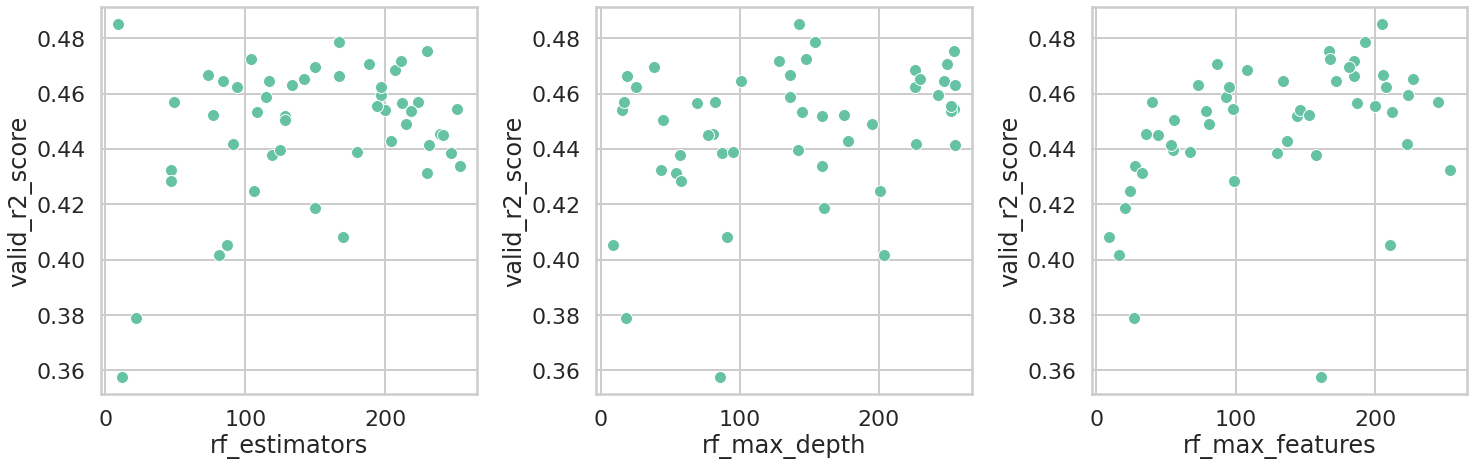

In [39]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

### Bayesian search

In [40]:
#define loss function
def lossfn(p):
    params["rf_estimators"] = int(p["rf_estimator"])
    params["rf_max_depth"] = int(p["rf_depth"])
    params["rf_max_features"] = int(p["rf_feature"])
    
    tparam = parse.wrapper(params)
    pl = mp.ModelPipeline(tparam)
    pl.train_model()
    perf_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = perf_data.get_prediction_results()
    r2 = pred_results['r2_score']
    return {'loss': 1-r2, 
            'status': STATUS_OK, 
            'model': tparam.model_tarball_path, 
            'rf_estimator': params["rf_estimators"],
            'rf_depth': params["rf_max_depth"],
            'rf_feature': params["rf_max_features"]}

space = {
    "rf_estimator": hp.uniform("rf_estimator", 8, 256),
    "rf_depth": hp.uniform("rf_depth", 8, 256),
    "rf_feature": hp.uniform("rf_feature", 8, 256)
}

In [41]:
trials = Trials()
best = fmin(lossfn, space, algo=tpe.suggest, max_evals=5, trials=trials)

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

2021-08-11 00:38:32,766 Attempting to load featurized dataset
2021-08-11 00:38:32,774 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:38:32,775 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:38:32,786 Featurizing sample 0
2021-08-11 00:38:38,529 Featurizing sample 1000


number of features: 1024
  0%|          | 0/5 [00:07<?, ?it/s, best loss: ?]

2021-08-11 00:38:40,693 Previous dataset split restored
2021-08-11 00:38:40,708 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/967b86c3-023a-4ee4-8538-1f5c2ec12e18/transformers.pkl
2021-08-11 00:38:40,709 Transforming response data
2021-08-11 00:38:40,733 Transforming response data
2021-08-11 00:38:40,745 Transforming response data
2021-08-11 00:38:40,779 Fitting random forest model
2021-08-11 00:38:43,172 Fold 0: training r2_score = 0.965, validation r2_score = 0.459, test r2_score = 0.529
2021-08-11 00:38:43,412 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/967b86c3-023a-4ee4-8538-1f5c2ec12e18/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_967b86c3-023a-4ee4-8538-1f5c2ec12e18.tar.gz
  0%|          | 0/5 [00:10<?, ?it/s, best loss: ?]

2021-08-11 00:38:43,542 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/967b86c3-023a-4ee4-8538-1f5c2ec12e18/model_metrics.json


 20%|██        | 1/5 [00:10<00:43, 10.79s/it, best loss: 0.5406452324588346]

2021-08-11 00:38:43,563 Attempting to load featurized dataset
2021-08-11 00:38:43,571 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:38:43,571 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:38:43,582 Featurizing sample 0
2021-08-11 00:38:49,292 Featurizing sample 1000


number of features: 1024
 20%|██        | 1/5 [00:18<00:43, 10.79s/it, best loss: 0.5406452324588346]

2021-08-11 00:38:51,432 Previous dataset split restored
2021-08-11 00:38:51,446 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8c77c037-dfde-4d32-a42c-54923abebe50/transformers.pkl
2021-08-11 00:38:51,447 Transforming response data
2021-08-11 00:38:51,473 Transforming response data
2021-08-11 00:38:51,485 Transforming response data
2021-08-11 00:38:51,509 Fitting random forest model
2021-08-11 00:38:52,469 Fold 0: training r2_score = 0.966, validation r2_score = 0.466, test r2_score = 0.534
2021-08-11 00:38:52,585 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8c77c037-dfde-4d32-a42c-54923abebe50/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_8c77c037-dfde-4d32-a42c-54923abebe50.tar.gz
 20%|██        | 1/5 [00:19<00:43, 10.79s/it, best loss: 0.5406452324588346]

2021-08-11 00:38:52,660 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8c77c037-dfde-4d32-a42c-54923abebe50/model_metrics.json


 40%|████      | 2/5 [00:19<00:30, 10.29s/it, best loss: 0.5337157936461089]

2021-08-11 00:38:52,679 Attempting to load featurized dataset
2021-08-11 00:38:52,686 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:38:52,688 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:38:52,699 Featurizing sample 0
2021-08-11 00:38:58,613 Featurizing sample 1000


number of features: 1024
 40%|████      | 2/5 [00:28<00:30, 10.29s/it, best loss: 0.5337157936461089]

2021-08-11 00:39:00,885 Previous dataset split restored
2021-08-11 00:39:00,898 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/dfd80396-b914-48e2-8923-46184d692e50/transformers.pkl
2021-08-11 00:39:00,900 Transforming response data
2021-08-11 00:39:00,924 Transforming response data
2021-08-11 00:39:00,936 Transforming response data
2021-08-11 00:39:00,960 Fitting random forest model
2021-08-11 00:39:01,943 Fold 0: training r2_score = 0.966, validation r2_score = 0.435, test r2_score = 0.523
2021-08-11 00:39:02,152 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/dfd80396-b914-48e2-8923-46184d692e50/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_dfd80396-b914-48e2-8923-46184d692e50.tar.gz
 40%|████      | 2/5 [00:29<00:30, 10.29s/it, best loss: 0.5337157936461089]

2021-08-11 00:39:02,277 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/dfd80396-b914-48e2-8923-46184d692e50/model_metrics.json


 60%|██████    | 3/5 [00:29<00:20, 10.09s/it, best loss: 0.5337157936461089]

2021-08-11 00:39:02,296 Attempting to load featurized dataset
2021-08-11 00:39:02,304 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:39:02,305 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:39:02,316 Featurizing sample 0
2021-08-11 00:39:08,258 Featurizing sample 1000


number of features: 1024
 60%|██████    | 3/5 [00:37<00:20, 10.09s/it, best loss: 0.5337157936461089]

2021-08-11 00:39:10,587 Previous dataset split restored
2021-08-11 00:39:10,605 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d16d8215-3429-4ef3-b5c5-50bb3cb0eea2/transformers.pkl
2021-08-11 00:39:10,606 Transforming response data
2021-08-11 00:39:10,634 Transforming response data
2021-08-11 00:39:10,646 Transforming response data
2021-08-11 00:39:10,671 Fitting random forest model
2021-08-11 00:39:12,726 Fold 0: training r2_score = 0.966, validation r2_score = 0.452, test r2_score = 0.534
2021-08-11 00:39:13,154 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d16d8215-3429-4ef3-b5c5-50bb3cb0eea2/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_d16d8215-3429-4ef3-b5c5-50bb3cb0eea2.tar.gz
 60%|██████    | 3/5 [00:40<00:20, 10.09s/it, best loss: 0.5337157936461089]

2021-08-11 00:39:13,425 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d16d8215-3429-4ef3-b5c5-50bb3cb0eea2/model_metrics.json


 80%|████████  | 4/5 [00:40<00:10, 10.41s/it, best loss: 0.5337157936461089]

2021-08-11 00:39:13,447 Attempting to load featurized dataset
2021-08-11 00:39:13,456 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:39:13,457 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:39:13,469 Featurizing sample 0
2021-08-11 00:39:19,566 Featurizing sample 1000


number of features: 1024
 80%|████████  | 4/5 [00:48<00:10, 10.41s/it, best loss: 0.5337157936461089]

2021-08-11 00:39:21,837 Previous dataset split restored
2021-08-11 00:39:21,855 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b0acb284-a83d-4504-b5e4-3cb02e4662cf/transformers.pkl
2021-08-11 00:39:21,856 Transforming response data
2021-08-11 00:39:21,880 Transforming response data
2021-08-11 00:39:21,895 Transforming response data
2021-08-11 00:39:21,923 Fitting random forest model
2021-08-11 00:39:23,413 Fold 0: training r2_score = 0.966, validation r2_score = 0.469, test r2_score = 0.534
2021-08-11 00:39:23,624 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b0acb284-a83d-4504-b5e4-3cb02e4662cf/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_b0acb284-a83d-4504-b5e4-3cb02e4662cf.tar.gz
 80%|████████  | 4/5 [00:50<00:10, 10.41s/it, best loss: 0.5337157936461089]

2021-08-11 00:39:23,746 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b0acb284-a83d-4504-b5e4-3cb02e4662cf/model_metrics.json


100%|██████████| 5/5 [00:51<00:00, 10.20s/it, best loss: 0.531354003278247]


(0.2, 0.6)

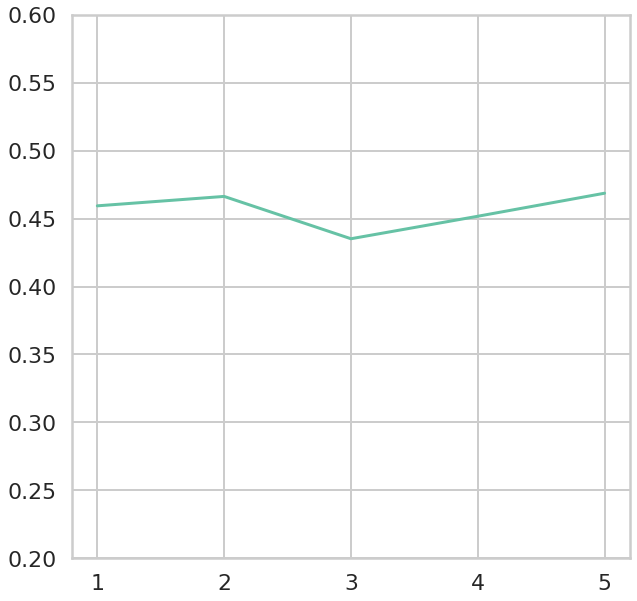

In [42]:
r2_list = [1-trials.trials[i]["result"]["loss"] for i in range(len(trials.trials))]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(x=list(range(1,len(trials.trials)+1)), y=r2_list, ax=ax)
ax.set_ylim(0.2,0.6)

In [43]:
rfe_list = [trials.trials[i]["result"]["rf_estimator"] for i in range(len(trials.trials))]
rfd_list = [trials.trials[i]["result"]["rf_depth"] for i in range(len(trials.trials))]
rff_list = [trials.trials[i]["result"]["rf_feature"] for i in range(len(trials.trials))]

In [44]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
4,107,244,128,0.468646
1,69,124,104,0.466284
0,146,142,243,0.459355
3,248,124,60,0.451685
2,126,60,30,0.435144


#### Save Bayesian optimization trial object and continue later

In [45]:
# save the trial object
trial_file = os.path.join("hp_trial.pkl")
with open(trial_file, "wb") as f:
    pickle.dump(trials, f)

In [46]:
# load the trial object
with open(trial_file, "rb") as f:
    new_trials = pickle.load(f)

In [47]:
# continue HPO
best = fmin(lossfn, space, algo=tpe.suggest, max_evals=50, trials=new_trials)

  0%|          | 0/45 [00:00<?, ?it/s, best loss: ?]

2021-08-11 00:39:24,250 Attempting to load featurized dataset
2021-08-11 00:39:24,258 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:39:24,259 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:39:24,270 Featurizing sample 0
2021-08-11 00:39:30,561 Featurizing sample 1000


number of features: 1024
  0%|          | 0/45 [00:08<?, ?it/s, best loss: ?]

2021-08-11 00:39:32,774 Previous dataset split restored
2021-08-11 00:39:32,789 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/489c2ba8-5ea7-4259-a304-c7212ca43647/transformers.pkl
2021-08-11 00:39:32,790 Transforming response data
2021-08-11 00:39:32,826 Transforming response data
2021-08-11 00:39:32,849 Transforming response data
2021-08-11 00:39:32,875 Fitting random forest model
2021-08-11 00:39:33,647 Fold 0: training r2_score = 0.964, validation r2_score = 0.415, test r2_score = 0.507
2021-08-11 00:39:33,806 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/489c2ba8-5ea7-4259-a304-c7212ca43647/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_489c2ba8-5ea7-4259-a304-c7212ca43647.tar.gz
  0%|          | 0/45 [00:09<?, ?it/s, best loss: ?]

2021-08-11 00:39:33,902 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/489c2ba8-5ea7-4259-a304-c7212ca43647/model_metrics.json


  2%|▏         | 1/45 [00:09<07:05,  9.67s/it, best loss: 0.531354003278247]

2021-08-11 00:39:33,924 Attempting to load featurized dataset
2021-08-11 00:39:33,935 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:39:33,939 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:39:33,950 Featurizing sample 0
2021-08-11 00:39:39,693 Featurizing sample 1000


number of features: 1024
  2%|▏         | 1/45 [00:17<07:05,  9.67s/it, best loss: 0.531354003278247]

2021-08-11 00:39:41,852 Previous dataset split restored
2021-08-11 00:39:41,865 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/7f2082b2-421f-4dc7-93bf-505f6d942bce/transformers.pkl
2021-08-11 00:39:41,869 Transforming response data
2021-08-11 00:39:41,893 Transforming response data
2021-08-11 00:39:41,911 Transforming response data
2021-08-11 00:39:41,938 Fitting random forest model
2021-08-11 00:39:42,698 Fold 0: training r2_score = 0.964, validation r2_score = 0.398, test r2_score = 0.507
2021-08-11 00:39:42,823 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7f2082b2-421f-4dc7-93bf-505f6d942bce/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_7f2082b2-421f-4dc7-93bf-505f6d942bce.tar.gz
  2%|▏         | 1/45 [00:18<07:05,  9.67s/it, best loss: 0.531354003278247]

2021-08-11 00:39:42,903 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7f2082b2-421f-4dc7-93bf-505f6d942bce/model_metrics.json


  4%|▍         | 2/45 [00:18<06:47,  9.47s/it, best loss: 0.531354003278247]

2021-08-11 00:39:42,922 Attempting to load featurized dataset
2021-08-11 00:39:42,931 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:39:42,931 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:39:42,943 Featurizing sample 0
2021-08-11 00:39:48,791 Featurizing sample 1000


number of features: 1024
  4%|▍         | 2/45 [00:26<06:47,  9.47s/it, best loss: 0.531354003278247]

2021-08-11 00:39:50,909 Previous dataset split restored
2021-08-11 00:39:50,923 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3856d240-4930-4af5-80aa-452faf62eb34/transformers.pkl
2021-08-11 00:39:50,925 Transforming response data
2021-08-11 00:39:50,952 Transforming response data
2021-08-11 00:39:50,963 Transforming response data
2021-08-11 00:39:50,989 Fitting random forest model
2021-08-11 00:39:53,382 Fold 0: training r2_score = 0.966, validation r2_score = 0.457, test r2_score = 0.530
2021-08-11 00:39:53,650 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3856d240-4930-4af5-80aa-452faf62eb34/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_3856d240-4930-4af5-80aa-452faf62eb34.tar.gz
  4%|▍         | 2/45 [00:29<06:47,  9.47s/it, best loss: 0.531354003278247]

2021-08-11 00:39:53,805 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3856d240-4930-4af5-80aa-452faf62eb34/model_metrics.json


  7%|▋         | 3/45 [00:29<06:55,  9.90s/it, best loss: 0.531354003278247]

2021-08-11 00:39:53,830 Attempting to load featurized dataset
2021-08-11 00:39:53,842 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:39:53,847 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:39:53,861 Featurizing sample 0
2021-08-11 00:39:59,660 Featurizing sample 1000


number of features: 1024
  7%|▋         | 3/45 [00:37<06:55,  9.90s/it, best loss: 0.531354003278247]

2021-08-11 00:40:01,823 Previous dataset split restored
2021-08-11 00:40:01,837 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/bd8624bf-1c1e-4b69-86b3-2013ae2584fb/transformers.pkl
2021-08-11 00:40:01,840 Transforming response data
2021-08-11 00:40:01,867 Transforming response data
2021-08-11 00:40:01,879 Transforming response data
2021-08-11 00:40:01,908 Fitting random forest model
2021-08-11 00:40:02,673 Fold 0: training r2_score = 0.964, validation r2_score = 0.402, test r2_score = 0.494
2021-08-11 00:40:02,813 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bd8624bf-1c1e-4b69-86b3-2013ae2584fb/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_bd8624bf-1c1e-4b69-86b3-2013ae2584fb.tar.gz
  7%|▋         | 3/45 [00:38<06:55,  9.90s/it, best loss: 0.531354003278247]

2021-08-11 00:40:02,908 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bd8624bf-1c1e-4b69-86b3-2013ae2584fb/model_metrics.json


  9%|▉         | 4/45 [00:38<06:36,  9.66s/it, best loss: 0.531354003278247]

2021-08-11 00:40:02,926 Attempting to load featurized dataset
2021-08-11 00:40:02,934 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:40:02,936 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:40:02,949 Featurizing sample 0
2021-08-11 00:40:08,706 Featurizing sample 1000


number of features: 1024
  9%|▉         | 4/45 [00:46<06:36,  9.66s/it, best loss: 0.531354003278247]

2021-08-11 00:40:10,930 Previous dataset split restored
2021-08-11 00:40:10,949 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a257332b-2a34-4f30-bfdf-8885e6f1d77c/transformers.pkl
2021-08-11 00:40:10,950 Transforming response data
2021-08-11 00:40:10,978 Transforming response data
2021-08-11 00:40:10,990 Transforming response data
2021-08-11 00:40:11,020 Fitting random forest model
2021-08-11 00:40:11,668 Fold 0: training r2_score = 0.961, validation r2_score = 0.415, test r2_score = 0.516
2021-08-11 00:40:11,733 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a257332b-2a34-4f30-bfdf-8885e6f1d77c/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_a257332b-2a34-4f30-bfdf-8885e6f1d77c.tar.gz
  9%|▉         | 4/45 [00:47<06:36,  9.66s/it, best loss: 0.531354003278247]

2021-08-11 00:40:11,775 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a257332b-2a34-4f30-bfdf-8885e6f1d77c/model_metrics.json


 11%|█         | 5/45 [00:47<06:16,  9.42s/it, best loss: 0.531354003278247]

2021-08-11 00:40:11,796 Attempting to load featurized dataset
2021-08-11 00:40:11,808 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:40:11,809 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:40:11,821 Featurizing sample 0
2021-08-11 00:40:18,078 Featurizing sample 1000


number of features: 1024
 11%|█         | 5/45 [00:56<06:16,  9.42s/it, best loss: 0.531354003278247]

2021-08-11 00:40:20,370 Previous dataset split restored
2021-08-11 00:40:20,384 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/86955c72-2391-4c5c-a0f5-8ca3ef533443/transformers.pkl
2021-08-11 00:40:20,387 Transforming response data
2021-08-11 00:40:20,408 Transforming response data
2021-08-11 00:40:20,423 Transforming response data
2021-08-11 00:40:20,454 Fitting random forest model
2021-08-11 00:40:20,994 Fold 0: training r2_score = 0.953, validation r2_score = 0.410, test r2_score = 0.455
2021-08-11 00:40:21,021 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/86955c72-2391-4c5c-a0f5-8ca3ef533443/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_86955c72-2391-4c5c-a0f5-8ca3ef533443.tar.gz
 11%|█         | 5/45 [00:56<06:16,  9.42s/it, best loss: 0.531354003278247]

2021-08-11 00:40:21,040 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/86955c72-2391-4c5c-a0f5-8ca3ef533443/model_metrics.json


 13%|█▎        | 6/45 [00:56<06:05,  9.37s/it, best loss: 0.531354003278247]

2021-08-11 00:40:21,064 Attempting to load featurized dataset
2021-08-11 00:40:21,072 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:40:21,073 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:40:21,086 Featurizing sample 0
2021-08-11 00:40:27,463 Featurizing sample 1000


number of features: 1024
 13%|█▎        | 6/45 [01:05<06:05,  9.37s/it, best loss: 0.531354003278247]

2021-08-11 00:40:29,780 Previous dataset split restored
2021-08-11 00:40:29,798 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/7bb521e4-8964-4eb3-a667-222811dc1deb/transformers.pkl
2021-08-11 00:40:29,799 Transforming response data
2021-08-11 00:40:29,824 Transforming response data
2021-08-11 00:40:29,839 Transforming response data
2021-08-11 00:40:29,864 Fitting random forest model
2021-08-11 00:40:31,059 Fold 0: training r2_score = 0.966, validation r2_score = 0.448, test r2_score = 0.536
2021-08-11 00:40:31,318 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7bb521e4-8964-4eb3-a667-222811dc1deb/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_7bb521e4-8964-4eb3-a667-222811dc1deb.tar.gz
 13%|█▎        | 6/45 [01:07<06:05,  9.37s/it, best loss: 0.531354003278247]

2021-08-11 00:40:31,476 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7bb521e4-8964-4eb3-a667-222811dc1deb/model_metrics.json


 16%|█▌        | 7/45 [01:07<06:08,  9.69s/it, best loss: 0.531354003278247]

2021-08-11 00:40:31,503 Attempting to load featurized dataset
2021-08-11 00:40:31,511 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:40:31,512 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:40:31,527 Featurizing sample 0
2021-08-11 00:40:37,702 Featurizing sample 1000


number of features: 1024
 16%|█▌        | 7/45 [01:15<06:08,  9.69s/it, best loss: 0.531354003278247]

2021-08-11 00:40:39,859 Previous dataset split restored
2021-08-11 00:40:39,871 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/5a76a05e-ccbf-41c2-9629-7544589c6205/transformers.pkl
2021-08-11 00:40:39,875 Transforming response data
2021-08-11 00:40:39,900 Transforming response data
2021-08-11 00:40:39,912 Transforming response data
2021-08-11 00:40:39,937 Fitting random forest model
2021-08-11 00:40:42,249 Fold 0: training r2_score = 0.966, validation r2_score = 0.457, test r2_score = 0.545
2021-08-11 00:40:42,569 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5a76a05e-ccbf-41c2-9629-7544589c6205/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_5a76a05e-ccbf-41c2-9629-7544589c6205.tar.gz
 16%|█▌        | 7/45 [01:18<06:08,  9.69s/it, best loss: 0.531354003278247]

2021-08-11 00:40:42,750 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5a76a05e-ccbf-41c2-9629-7544589c6205/model_metrics.json


 18%|█▊        | 8/45 [01:18<06:16, 10.17s/it, best loss: 0.531354003278247]

2021-08-11 00:40:42,771 Attempting to load featurized dataset
2021-08-11 00:40:42,779 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:40:42,779 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:40:42,791 Featurizing sample 0
2021-08-11 00:40:48,516 Featurizing sample 1000


number of features: 1024
 18%|█▊        | 8/45 [01:26<06:16, 10.17s/it, best loss: 0.531354003278247]

2021-08-11 00:40:50,681 Previous dataset split restored
2021-08-11 00:40:50,694 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/48972192-71a4-4030-bd67-60430c5df379/transformers.pkl
2021-08-11 00:40:50,698 Transforming response data
2021-08-11 00:40:50,725 Transforming response data
2021-08-11 00:40:50,783 Transforming response data
2021-08-11 00:40:50,810 Fitting random forest model
2021-08-11 00:40:51,355 Fold 0: training r2_score = 0.958, validation r2_score = 0.455, test r2_score = 0.538
2021-08-11 00:40:51,398 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/48972192-71a4-4030-bd67-60430c5df379/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_48972192-71a4-4030-bd67-60430c5df379.tar.gz
 18%|█▊        | 8/45 [01:27<06:16, 10.17s/it, best loss: 0.531354003278247]

2021-08-11 00:40:51,434 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/48972192-71a4-4030-bd67-60430c5df379/model_metrics.json


 20%|██        | 9/45 [01:27<05:50,  9.72s/it, best loss: 0.531354003278247]

2021-08-11 00:40:51,454 Attempting to load featurized dataset
2021-08-11 00:40:51,463 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:40:51,465 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:40:51,477 Featurizing sample 0
2021-08-11 00:40:57,187 Featurizing sample 1000


number of features: 1024
 20%|██        | 9/45 [01:35<05:50,  9.72s/it, best loss: 0.531354003278247]

2021-08-11 00:40:59,331 Previous dataset split restored
2021-08-11 00:40:59,344 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/2f2f9fc5-54ef-4003-896e-6bc8163ce6d9/transformers.pkl
2021-08-11 00:40:59,347 Transforming response data
2021-08-11 00:40:59,370 Transforming response data
2021-08-11 00:40:59,382 Transforming response data
2021-08-11 00:40:59,405 Fitting random forest model
2021-08-11 00:41:01,151 Fold 0: training r2_score = 0.967, validation r2_score = 0.449, test r2_score = 0.534
2021-08-11 00:41:01,549 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2f2f9fc5-54ef-4003-896e-6bc8163ce6d9/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_2f2f9fc5-54ef-4003-896e-6bc8163ce6d9.tar.gz
 20%|██        | 9/45 [01:37<05:50,  9.72s/it, best loss: 0.531354003278247]

2021-08-11 00:41:01,765 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2f2f9fc5-54ef-4003-896e-6bc8163ce6d9/model_metrics.json


 22%|██▏       | 10/45 [01:37<05:46,  9.91s/it, best loss: 0.531354003278247]

2021-08-11 00:41:01,787 Attempting to load featurized dataset
2021-08-11 00:41:01,795 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:41:01,796 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:41:01,807 Featurizing sample 0
2021-08-11 00:41:07,703 Featurizing sample 1000


number of features: 1024
 22%|██▏       | 10/45 [01:45<05:46,  9.91s/it, best loss: 0.531354003278247]

2021-08-11 00:41:09,859 Previous dataset split restored
2021-08-11 00:41:09,873 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ed03170b-e5bf-4167-ba58-b66a04b16c06/transformers.pkl
2021-08-11 00:41:09,874 Transforming response data
2021-08-11 00:41:09,902 Transforming response data
2021-08-11 00:41:09,914 Transforming response data
2021-08-11 00:41:09,944 Fitting random forest model
2021-08-11 00:41:10,896 Fold 0: training r2_score = 0.963, validation r2_score = 0.399, test r2_score = 0.527
2021-08-11 00:41:10,964 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ed03170b-e5bf-4167-ba58-b66a04b16c06/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_ed03170b-e5bf-4167-ba58-b66a04b16c06.tar.gz
 22%|██▏       | 10/45 [01:46<05:46,  9.91s/it, best loss: 0.531354003278247]

2021-08-11 00:41:11,016 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ed03170b-e5bf-4167-ba58-b66a04b16c06/model_metrics.json


 24%|██▍       | 11/45 [01:46<05:30,  9.71s/it, best loss: 0.531354003278247]

2021-08-11 00:41:11,037 Attempting to load featurized dataset
2021-08-11 00:41:11,046 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:41:11,047 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:41:11,059 Featurizing sample 0
2021-08-11 00:41:16,853 Featurizing sample 1000


number of features: 1024
 24%|██▍       | 11/45 [01:54<05:30,  9.71s/it, best loss: 0.531354003278247]

2021-08-11 00:41:19,222 Previous dataset split restored
2021-08-11 00:41:19,243 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/02ae994d-84ce-420c-98bb-cf47e4181181/transformers.pkl
2021-08-11 00:41:19,248 Transforming response data
2021-08-11 00:41:19,270 Transforming response data
2021-08-11 00:41:19,284 Transforming response data
2021-08-11 00:41:19,310 Fitting random forest model
2021-08-11 00:41:20,165 Fold 0: training r2_score = 0.963, validation r2_score = 0.458, test r2_score = 0.510
2021-08-11 00:41:20,250 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/02ae994d-84ce-420c-98bb-cf47e4181181/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_02ae994d-84ce-420c-98bb-cf47e4181181.tar.gz
 24%|██▍       | 11/45 [01:56<05:30,  9.71s/it, best loss: 0.531354003278247]

2021-08-11 00:41:20,307 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/02ae994d-84ce-420c-98bb-cf47e4181181/model_metrics.json


 27%|██▋       | 12/45 [01:56<05:16,  9.58s/it, best loss: 0.531354003278247]

2021-08-11 00:41:20,326 Attempting to load featurized dataset
2021-08-11 00:41:20,335 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:41:20,336 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:41:20,348 Featurizing sample 0
2021-08-11 00:41:26,540 Featurizing sample 1000


number of features: 1024
 27%|██▋       | 12/45 [02:04<05:16,  9.58s/it, best loss: 0.531354003278247]

2021-08-11 00:41:28,815 Previous dataset split restored
2021-08-11 00:41:28,832 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/2db6ccf9-e45e-46ff-ad9a-f455fd80f17b/transformers.pkl
2021-08-11 00:41:28,833 Transforming response data
2021-08-11 00:41:28,864 Transforming response data
2021-08-11 00:41:28,879 Transforming response data
2021-08-11 00:41:28,906 Fitting random forest model
2021-08-11 00:41:30,174 Fold 0: training r2_score = 0.964, validation r2_score = 0.458, test r2_score = 0.543
2021-08-11 00:41:30,337 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2db6ccf9-e45e-46ff-ad9a-f455fd80f17b/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_2db6ccf9-e45e-46ff-ad9a-f455fd80f17b.tar.gz
 27%|██▋       | 12/45 [02:06<05:16,  9.58s/it, best loss: 0.531354003278247]

2021-08-11 00:41:30,427 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2db6ccf9-e45e-46ff-ad9a-f455fd80f17b/model_metrics.json


 29%|██▉       | 13/45 [02:06<05:11,  9.75s/it, best loss: 0.531354003278247]

2021-08-11 00:41:30,449 Attempting to load featurized dataset
2021-08-11 00:41:30,458 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:41:30,459 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:41:30,475 Featurizing sample 0
2021-08-11 00:41:36,836 Featurizing sample 1000


number of features: 1024
 29%|██▉       | 13/45 [02:14<05:11,  9.75s/it, best loss: 0.531354003278247]

2021-08-11 00:41:39,229 Previous dataset split restored
2021-08-11 00:41:39,244 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8004b162-aa12-44b8-b799-e52a2f04e889/transformers.pkl
2021-08-11 00:41:39,249 Transforming response data
2021-08-11 00:41:39,279 Transforming response data
2021-08-11 00:41:39,291 Transforming response data
2021-08-11 00:41:39,318 Fitting random forest model
2021-08-11 00:41:41,126 Fold 0: training r2_score = 0.967, validation r2_score = 0.461, test r2_score = 0.528
2021-08-11 00:41:41,453 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8004b162-aa12-44b8-b799-e52a2f04e889/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_8004b162-aa12-44b8-b799-e52a2f04e889.tar.gz
 29%|██▉       | 13/45 [02:17<05:11,  9.75s/it, best loss: 0.531354003278247]

2021-08-11 00:41:41,645 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8004b162-aa12-44b8-b799-e52a2f04e889/model_metrics.json


 31%|███       | 14/45 [02:17<05:15, 10.19s/it, best loss: 0.531354003278247]

2021-08-11 00:41:41,668 Attempting to load featurized dataset
2021-08-11 00:41:41,679 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:41:41,680 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:41:41,695 Featurizing sample 0
2021-08-11 00:41:47,639 Featurizing sample 1000


number of features: 1024
 31%|███       | 14/45 [02:25<05:15, 10.19s/it, best loss: 0.531354003278247]

2021-08-11 00:41:49,812 Previous dataset split restored
2021-08-11 00:41:49,825 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9641b65b-1b4a-4275-8b6c-7b7601ec2e1c/transformers.pkl
2021-08-11 00:41:49,831 Transforming response data
2021-08-11 00:41:49,854 Transforming response data
2021-08-11 00:41:49,867 Transforming response data
2021-08-11 00:41:49,893 Fitting random forest model
2021-08-11 00:41:51,269 Fold 0: training r2_score = 0.966, validation r2_score = 0.470, test r2_score = 0.527
2021-08-11 00:41:51,464 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9641b65b-1b4a-4275-8b6c-7b7601ec2e1c/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_9641b65b-1b4a-4275-8b6c-7b7601ec2e1c.tar.gz
 31%|███       | 14/45 [02:27<05:15, 10.19s/it, best loss: 0.531354003278247]

2021-08-11 00:41:51,576 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9641b65b-1b4a-4275-8b6c-7b7601ec2e1c/model_metrics.json


 33%|███▎      | 15/45 [02:27<05:03, 10.11s/it, best loss: 0.5301050342274042]

2021-08-11 00:41:51,608 Attempting to load featurized dataset
2021-08-11 00:41:51,618 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:41:51,620 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:41:51,634 Featurizing sample 0
2021-08-11 00:41:57,437 Featurizing sample 1000


number of features: 1024
 33%|███▎      | 15/45 [02:35<05:03, 10.11s/it, best loss: 0.5301050342274042]

2021-08-11 00:41:59,618 Previous dataset split restored
2021-08-11 00:41:59,635 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/436d034f-e652-4427-b8d5-2412fdfc5153/transformers.pkl
2021-08-11 00:41:59,636 Transforming response data
2021-08-11 00:41:59,662 Transforming response data
2021-08-11 00:41:59,673 Transforming response data
2021-08-11 00:41:59,698 Fitting random forest model
2021-08-11 00:42:00,968 Fold 0: training r2_score = 0.966, validation r2_score = 0.459, test r2_score = 0.548
2021-08-11 00:42:01,153 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/436d034f-e652-4427-b8d5-2412fdfc5153/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_436d034f-e652-4427-b8d5-2412fdfc5153.tar.gz
 33%|███▎      | 15/45 [02:37<05:03, 10.11s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:01,276 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/436d034f-e652-4427-b8d5-2412fdfc5153/model_metrics.json


 36%|███▌      | 16/45 [02:37<04:49,  9.99s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:01,311 Attempting to load featurized dataset
2021-08-11 00:42:01,321 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:42:01,322 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:42:01,335 Featurizing sample 0
2021-08-11 00:42:07,194 Featurizing sample 1000


number of features: 1024
 36%|███▌      | 16/45 [02:45<04:49,  9.99s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:09,363 Previous dataset split restored
2021-08-11 00:42:09,376 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/cf17447e-812a-4872-84bd-f34c65298631/transformers.pkl
2021-08-11 00:42:09,379 Transforming response data
2021-08-11 00:42:09,405 Transforming response data
2021-08-11 00:42:09,422 Transforming response data
2021-08-11 00:42:09,446 Fitting random forest model
2021-08-11 00:42:11,221 Fold 0: training r2_score = 0.966, validation r2_score = 0.465, test r2_score = 0.538
2021-08-11 00:42:11,417 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/cf17447e-812a-4872-84bd-f34c65298631/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_cf17447e-812a-4872-84bd-f34c65298631.tar.gz
 36%|███▌      | 16/45 [02:47<04:49,  9.99s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:11,532 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/cf17447e-812a-4872-84bd-f34c65298631/model_metrics.json


 38%|███▊      | 17/45 [02:47<04:41, 10.07s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:11,563 Attempting to load featurized dataset
2021-08-11 00:42:11,572 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:42:11,573 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:42:11,586 Featurizing sample 0
2021-08-11 00:42:17,397 Featurizing sample 1000


number of features: 1024
 38%|███▊      | 17/45 [02:55<04:41, 10.07s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:19,633 Previous dataset split restored
2021-08-11 00:42:19,648 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/41c6aa56-5ea9-42f5-8d1c-a3f00bed242b/transformers.pkl
2021-08-11 00:42:19,652 Transforming response data
2021-08-11 00:42:19,678 Transforming response data
2021-08-11 00:42:19,690 Transforming response data
2021-08-11 00:42:19,714 Fitting random forest model
2021-08-11 00:42:21,501 Fold 0: training r2_score = 0.965, validation r2_score = 0.458, test r2_score = 0.528
2021-08-11 00:42:21,756 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/41c6aa56-5ea9-42f5-8d1c-a3f00bed242b/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_41c6aa56-5ea9-42f5-8d1c-a3f00bed242b.tar.gz
 38%|███▊      | 17/45 [02:57<04:41, 10.07s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:21,898 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/41c6aa56-5ea9-42f5-8d1c-a3f00bed242b/model_metrics.json


 40%|████      | 18/45 [02:57<04:34, 10.16s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:21,929 Attempting to load featurized dataset
2021-08-11 00:42:21,937 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:42:21,939 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:42:21,950 Featurizing sample 0
2021-08-11 00:42:28,019 Featurizing sample 1000


number of features: 1024
 40%|████      | 18/45 [03:06<04:34, 10.16s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:30,342 Previous dataset split restored
2021-08-11 00:42:30,357 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/02724749-c157-4220-94db-a75b60b1eca1/transformers.pkl
2021-08-11 00:42:30,361 Transforming response data
2021-08-11 00:42:30,388 Transforming response data
2021-08-11 00:42:30,400 Transforming response data
2021-08-11 00:42:30,424 Fitting random forest model
2021-08-11 00:42:31,588 Fold 0: training r2_score = 0.965, validation r2_score = 0.438, test r2_score = 0.504
2021-08-11 00:42:31,712 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/02724749-c157-4220-94db-a75b60b1eca1/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_02724749-c157-4220-94db-a75b60b1eca1.tar.gz
 40%|████      | 18/45 [03:07<04:34, 10.16s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:31,777 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/02724749-c157-4220-94db-a75b60b1eca1/model_metrics.json


 42%|████▏     | 19/45 [03:07<04:21, 10.07s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:31,813 Attempting to load featurized dataset
2021-08-11 00:42:31,822 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:42:31,823 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:42:31,838 Featurizing sample 0
2021-08-11 00:42:38,013 Featurizing sample 1000


number of features: 1024
 42%|████▏     | 19/45 [03:16<04:21, 10.07s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:40,336 Previous dataset split restored
2021-08-11 00:42:40,352 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/1adf50b9-9f84-4997-bbcc-d16e02bdb12e/transformers.pkl
2021-08-11 00:42:40,353 Transforming response data
2021-08-11 00:42:40,386 Transforming response data
2021-08-11 00:42:40,397 Transforming response data
2021-08-11 00:42:40,422 Fitting random forest model
2021-08-11 00:42:41,598 Fold 0: training r2_score = 0.957, validation r2_score = 0.446, test r2_score = 0.526
2021-08-11 00:42:41,773 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1adf50b9-9f84-4997-bbcc-d16e02bdb12e/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_1adf50b9-9f84-4997-bbcc-d16e02bdb12e.tar.gz
 42%|████▏     | 19/45 [03:17<04:21, 10.07s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:41,879 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1adf50b9-9f84-4997-bbcc-d16e02bdb12e/model_metrics.json


 44%|████▍     | 20/45 [03:17<04:12, 10.08s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:41,904 Attempting to load featurized dataset
2021-08-11 00:42:41,914 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:42:41,915 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:42:41,929 Featurizing sample 0
2021-08-11 00:42:48,158 Featurizing sample 1000


number of features: 1024
 44%|████▍     | 20/45 [03:26<04:12, 10.08s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:50,357 Previous dataset split restored
2021-08-11 00:42:50,373 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8ce015b2-5bfb-4d2e-b380-170803ad743e/transformers.pkl
2021-08-11 00:42:50,374 Transforming response data
2021-08-11 00:42:50,400 Transforming response data
2021-08-11 00:42:50,412 Transforming response data
2021-08-11 00:42:50,437 Fitting random forest model
2021-08-11 00:42:52,847 Fold 0: training r2_score = 0.966, validation r2_score = 0.468, test r2_score = 0.545
2021-08-11 00:42:53,193 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8ce015b2-5bfb-4d2e-b380-170803ad743e/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_8ce015b2-5bfb-4d2e-b380-170803ad743e.tar.gz
 44%|████▍     | 20/45 [03:29<04:12, 10.08s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:53,396 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8ce015b2-5bfb-4d2e-b380-170803ad743e/model_metrics.json


 47%|████▋     | 21/45 [03:29<04:12, 10.51s/it, best loss: 0.5301050342274042]

2021-08-11 00:42:53,425 Attempting to load featurized dataset
2021-08-11 00:42:53,433 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:42:53,434 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:42:53,446 Featurizing sample 0
2021-08-11 00:42:59,345 Featurizing sample 1000


number of features: 1024
 47%|████▋     | 21/45 [03:37<04:12, 10.51s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:01,502 Previous dataset split restored
2021-08-11 00:43:01,518 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/78e4115a-75ee-4d8f-a850-0afa460e8c37/transformers.pkl
2021-08-11 00:43:01,519 Transforming response data
2021-08-11 00:43:01,545 Transforming response data
2021-08-11 00:43:01,557 Transforming response data
2021-08-11 00:43:01,582 Fitting random forest model
2021-08-11 00:43:03,378 Fold 0: training r2_score = 0.964, validation r2_score = 0.458, test r2_score = 0.531
2021-08-11 00:43:03,649 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/78e4115a-75ee-4d8f-a850-0afa460e8c37/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_78e4115a-75ee-4d8f-a850-0afa460e8c37.tar.gz
 47%|████▋     | 21/45 [03:39<04:12, 10.51s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:03,819 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/78e4115a-75ee-4d8f-a850-0afa460e8c37/model_metrics.json


 49%|████▉     | 22/45 [03:39<04:01, 10.49s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:03,849 Attempting to load featurized dataset
2021-08-11 00:43:03,858 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:43:03,859 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:43:03,873 Featurizing sample 0
2021-08-11 00:43:09,668 Featurizing sample 1000


number of features: 1024
 49%|████▉     | 22/45 [03:47<04:01, 10.49s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:11,863 Previous dataset split restored
2021-08-11 00:43:11,878 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d39e063e-0cb6-47b3-9a40-c88b245d29d4/transformers.pkl
2021-08-11 00:43:11,879 Transforming response data
2021-08-11 00:43:11,907 Transforming response data
2021-08-11 00:43:11,921 Transforming response data
2021-08-11 00:43:11,948 Fitting random forest model
2021-08-11 00:43:13,840 Fold 0: training r2_score = 0.966, validation r2_score = 0.464, test r2_score = 0.517
2021-08-11 00:43:14,062 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d39e063e-0cb6-47b3-9a40-c88b245d29d4/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_d39e063e-0cb6-47b3-9a40-c88b245d29d4.tar.gz
 49%|████▉     | 22/45 [03:49<04:01, 10.49s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:14,194 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d39e063e-0cb6-47b3-9a40-c88b245d29d4/model_metrics.json


 51%|█████     | 23/45 [03:49<03:49, 10.45s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:14,226 Attempting to load featurized dataset
2021-08-11 00:43:14,237 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:43:14,238 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:43:14,250 Featurizing sample 0
2021-08-11 00:43:20,001 Featurizing sample 1000


number of features: 1024
 51%|█████     | 23/45 [03:57<03:49, 10.45s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:22,168 Previous dataset split restored
2021-08-11 00:43:22,184 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3e204669-07d9-4121-acfd-c13a62b5ab18/transformers.pkl
2021-08-11 00:43:22,188 Transforming response data
2021-08-11 00:43:22,218 Transforming response data
2021-08-11 00:43:22,234 Transforming response data
2021-08-11 00:43:22,272 Fitting random forest model
2021-08-11 00:43:24,678 Fold 0: training r2_score = 0.966, validation r2_score = 0.465, test r2_score = 0.537
2021-08-11 00:43:24,929 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3e204669-07d9-4121-acfd-c13a62b5ab18/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_3e204669-07d9-4121-acfd-c13a62b5ab18.tar.gz
 51%|█████     | 23/45 [04:00<03:49, 10.45s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:25,069 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3e204669-07d9-4121-acfd-c13a62b5ab18/model_metrics.json


 53%|█████▎    | 24/45 [04:00<03:42, 10.58s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:25,105 Attempting to load featurized dataset
2021-08-11 00:43:25,114 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:43:25,115 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:43:25,129 Featurizing sample 0
2021-08-11 00:43:31,006 Featurizing sample 1000


number of features: 1024
 53%|█████▎    | 24/45 [04:09<03:42, 10.58s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:33,327 Previous dataset split restored
2021-08-11 00:43:33,343 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a6096c36-7e5a-4eb5-a28b-2f42527298b1/transformers.pkl
2021-08-11 00:43:33,345 Transforming response data
2021-08-11 00:43:33,373 Transforming response data
2021-08-11 00:43:33,387 Transforming response data
2021-08-11 00:43:33,413 Fitting random forest model
2021-08-11 00:43:34,589 Fold 0: training r2_score = 0.966, validation r2_score = 0.469, test r2_score = 0.536
2021-08-11 00:43:34,775 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a6096c36-7e5a-4eb5-a28b-2f42527298b1/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_a6096c36-7e5a-4eb5-a28b-2f42527298b1.tar.gz
 53%|█████▎    | 24/45 [04:10<03:42, 10.58s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:34,889 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a6096c36-7e5a-4eb5-a28b-2f42527298b1/model_metrics.json


 56%|█████▌    | 25/45 [04:10<03:27, 10.35s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:34,920 Attempting to load featurized dataset
2021-08-11 00:43:34,929 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:43:34,930 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:43:34,945 Featurizing sample 0
2021-08-11 00:43:41,091 Featurizing sample 1000


number of features: 1024
 56%|█████▌    | 25/45 [04:19<03:27, 10.35s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:43,377 Previous dataset split restored
2021-08-11 00:43:43,396 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/36ac54af-7b41-45e7-935c-1f1621ed7157/transformers.pkl
2021-08-11 00:43:43,397 Transforming response data
2021-08-11 00:43:43,426 Transforming response data
2021-08-11 00:43:43,438 Transforming response data
2021-08-11 00:43:43,463 Fitting random forest model
2021-08-11 00:43:44,425 Fold 0: training r2_score = 0.964, validation r2_score = 0.453, test r2_score = 0.541
2021-08-11 00:43:44,537 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/36ac54af-7b41-45e7-935c-1f1621ed7157/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_36ac54af-7b41-45e7-935c-1f1621ed7157.tar.gz
 56%|█████▌    | 25/45 [04:20<03:27, 10.35s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:44,615 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/36ac54af-7b41-45e7-935c-1f1621ed7157/model_metrics.json


 58%|█████▊    | 26/45 [04:20<03:13, 10.16s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:44,646 Attempting to load featurized dataset
2021-08-11 00:43:44,657 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:43:44,658 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:43:44,682 Featurizing sample 0
2021-08-11 00:43:50,861 Featurizing sample 1000


number of features: 1024
 58%|█████▊    | 26/45 [04:28<03:13, 10.16s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:53,226 Previous dataset split restored
2021-08-11 00:43:53,239 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/724783ff-77d0-45e7-a29b-98ec695eea1a/transformers.pkl
2021-08-11 00:43:53,243 Transforming response data
2021-08-11 00:43:53,270 Transforming response data
2021-08-11 00:43:53,282 Transforming response data
2021-08-11 00:43:53,309 Fitting random forest model
2021-08-11 00:43:54,790 Fold 0: training r2_score = 0.966, validation r2_score = 0.451, test r2_score = 0.532
2021-08-11 00:43:54,993 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/724783ff-77d0-45e7-a29b-98ec695eea1a/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_724783ff-77d0-45e7-a29b-98ec695eea1a.tar.gz
 58%|█████▊    | 26/45 [04:30<03:13, 10.16s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:55,112 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/724783ff-77d0-45e7-a29b-98ec695eea1a/model_metrics.json


 60%|██████    | 27/45 [04:30<03:04, 10.26s/it, best loss: 0.5301050342274042]

2021-08-11 00:43:55,137 Attempting to load featurized dataset
2021-08-11 00:43:55,146 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:43:55,147 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:43:55,160 Featurizing sample 0
2021-08-11 00:44:01,016 Featurizing sample 1000


number of features: 1024
 60%|██████    | 27/45 [04:38<03:04, 10.26s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:03,255 Previous dataset split restored
2021-08-11 00:44:03,273 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/4d3a895c-f38a-4e4d-a71b-4852d079a7d7/transformers.pkl
2021-08-11 00:44:03,275 Transforming response data
2021-08-11 00:44:03,300 Transforming response data
2021-08-11 00:44:03,314 Transforming response data
2021-08-11 00:44:03,343 Fitting random forest model
2021-08-11 00:44:04,635 Fold 0: training r2_score = 0.966, validation r2_score = 0.428, test r2_score = 0.529
2021-08-11 00:44:04,876 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4d3a895c-f38a-4e4d-a71b-4852d079a7d7/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_4d3a895c-f38a-4e4d-a71b-4852d079a7d7.tar.gz
 60%|██████    | 27/45 [04:40<03:04, 10.26s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:05,073 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4d3a895c-f38a-4e4d-a71b-4852d079a7d7/model_metrics.json


 62%|██████▏   | 28/45 [04:40<02:52, 10.17s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:05,103 Attempting to load featurized dataset
2021-08-11 00:44:05,113 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:44:05,114 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:44:05,131 Featurizing sample 0
2021-08-11 00:44:11,265 Featurizing sample 1000


number of features: 1024
 62%|██████▏   | 28/45 [04:49<02:52, 10.17s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:13,593 Previous dataset split restored
2021-08-11 00:44:13,607 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/f5ae0d86-cbad-4795-82f4-ee19cfeabcb1/transformers.pkl
2021-08-11 00:44:13,610 Transforming response data
2021-08-11 00:44:13,637 Transforming response data
2021-08-11 00:44:13,649 Transforming response data
2021-08-11 00:44:13,679 Fitting random forest model
2021-08-11 00:44:14,550 Fold 0: training r2_score = 0.832, validation r2_score = 0.387, test r2_score = 0.500
2021-08-11 00:44:14,626 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f5ae0d86-cbad-4795-82f4-ee19cfeabcb1/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_f5ae0d86-cbad-4795-82f4-ee19cfeabcb1.tar.gz
 62%|██████▏   | 28/45 [04:50<02:52, 10.17s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:14,665 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f5ae0d86-cbad-4795-82f4-ee19cfeabcb1/model_metrics.json


 64%|██████▍   | 29/45 [04:50<02:39, 10.00s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:14,700 Attempting to load featurized dataset
2021-08-11 00:44:14,710 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:44:14,711 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:44:14,734 Featurizing sample 0
2021-08-11 00:44:20,876 Featurizing sample 1000


number of features: 1024
 64%|██████▍   | 29/45 [04:58<02:39, 10.00s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:23,267 Previous dataset split restored
2021-08-11 00:44:23,284 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/e38f88b0-5a30-4b32-a2c4-0872d68a123e/transformers.pkl
2021-08-11 00:44:23,286 Transforming response data
2021-08-11 00:44:23,313 Transforming response data
2021-08-11 00:44:23,326 Transforming response data
2021-08-11 00:44:23,354 Fitting random forest model
2021-08-11 00:44:24,117 Fold 0: training r2_score = 0.966, validation r2_score = 0.441, test r2_score = 0.511
2021-08-11 00:44:24,256 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e38f88b0-5a30-4b32-a2c4-0872d68a123e/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_e38f88b0-5a30-4b32-a2c4-0872d68a123e.tar.gz
 64%|██████▍   | 29/45 [05:00<02:39, 10.00s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:24,339 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e38f88b0-5a30-4b32-a2c4-0872d68a123e/model_metrics.json


 67%|██████▋   | 30/45 [05:00<02:28,  9.90s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:24,376 Attempting to load featurized dataset
2021-08-11 00:44:24,390 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:44:24,391 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:44:24,406 Featurizing sample 0
2021-08-11 00:44:30,344 Featurizing sample 1000


number of features: 1024
 67%|██████▋   | 30/45 [05:08<02:28,  9.90s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:32,507 Previous dataset split restored
2021-08-11 00:44:32,523 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/5ee125dd-a6a2-4abd-a785-387050bd823b/transformers.pkl
2021-08-11 00:44:32,524 Transforming response data
2021-08-11 00:44:32,549 Transforming response data
2021-08-11 00:44:32,566 Transforming response data
2021-08-11 00:44:32,592 Fitting random forest model
2021-08-11 00:44:33,869 Fold 0: training r2_score = 0.965, validation r2_score = 0.463, test r2_score = 0.540
2021-08-11 00:44:34,051 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5ee125dd-a6a2-4abd-a785-387050bd823b/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_5ee125dd-a6a2-4abd-a785-387050bd823b.tar.gz
 67%|██████▋   | 30/45 [05:09<02:28,  9.90s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:34,159 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5ee125dd-a6a2-4abd-a785-387050bd823b/model_metrics.json


 69%|██████▉   | 31/45 [05:09<02:18,  9.88s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:34,198 Attempting to load featurized dataset
2021-08-11 00:44:34,207 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:44:34,208 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:44:34,222 Featurizing sample 0
2021-08-11 00:44:40,143 Featurizing sample 1000


number of features: 1024
 69%|██████▉   | 31/45 [05:17<02:18,  9.88s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:42,306 Previous dataset split restored
2021-08-11 00:44:42,321 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8ff4e577-d796-4ad4-abac-8f9ba59e7e5b/transformers.pkl
2021-08-11 00:44:42,324 Transforming response data
2021-08-11 00:44:42,349 Transforming response data
2021-08-11 00:44:42,361 Transforming response data
2021-08-11 00:44:42,387 Fitting random forest model
2021-08-11 00:44:44,890 Fold 0: training r2_score = 0.966, validation r2_score = 0.484, test r2_score = 0.534
2021-08-11 00:44:45,159 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8ff4e577-d796-4ad4-abac-8f9ba59e7e5b/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_8ff4e577-d796-4ad4-abac-8f9ba59e7e5b.tar.gz
 69%|██████▉   | 31/45 [05:21<02:18,  9.88s/it, best loss: 0.5301050342274042]

2021-08-11 00:44:45,325 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8ff4e577-d796-4ad4-abac-8f9ba59e7e5b/model_metrics.json


 71%|███████   | 32/45 [05:21<02:13, 10.26s/it, best loss: 0.5156884491580335]

2021-08-11 00:44:45,356 Attempting to load featurized dataset
2021-08-11 00:44:45,366 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:44:45,367 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:44:45,380 Featurizing sample 0
2021-08-11 00:44:51,245 Featurizing sample 1000


number of features: 1024
 71%|███████   | 32/45 [05:29<02:13, 10.26s/it, best loss: 0.5156884491580335]

2021-08-11 00:44:53,377 Previous dataset split restored
2021-08-11 00:44:53,394 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/be5ded17-d490-4380-a8c6-269a3ea137a3/transformers.pkl
2021-08-11 00:44:53,395 Transforming response data
2021-08-11 00:44:53,422 Transforming response data
2021-08-11 00:44:53,436 Transforming response data
2021-08-11 00:44:53,468 Fitting random forest model
2021-08-11 00:44:56,676 Fold 0: training r2_score = 0.966, validation r2_score = 0.458, test r2_score = 0.520
2021-08-11 00:44:57,028 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/be5ded17-d490-4380-a8c6-269a3ea137a3/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_be5ded17-d490-4380-a8c6-269a3ea137a3.tar.gz
 71%|███████   | 32/45 [05:32<02:13, 10.26s/it, best loss: 0.5156884491580335]

2021-08-11 00:44:57,216 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/be5ded17-d490-4380-a8c6-269a3ea137a3/model_metrics.json


 73%|███████▎  | 33/45 [05:32<02:09, 10.75s/it, best loss: 0.5156884491580335]

2021-08-11 00:44:57,243 Attempting to load featurized dataset
2021-08-11 00:44:57,252 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:44:57,253 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:44:57,267 Featurizing sample 0
2021-08-11 00:45:03,108 Featurizing sample 1000


number of features: 1024
 73%|███████▎  | 33/45 [05:40<02:09, 10.75s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:05,308 Previous dataset split restored
2021-08-11 00:45:05,324 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/356792fc-f0ba-4793-8cd3-4afbd2eb511e/transformers.pkl
2021-08-11 00:45:05,325 Transforming response data
2021-08-11 00:45:05,352 Transforming response data
2021-08-11 00:45:05,365 Transforming response data
2021-08-11 00:45:05,391 Fitting random forest model
2021-08-11 00:45:08,713 Fold 0: training r2_score = 0.966, validation r2_score = 0.461, test r2_score = 0.533
2021-08-11 00:45:09,159 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/356792fc-f0ba-4793-8cd3-4afbd2eb511e/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_356792fc-f0ba-4793-8cd3-4afbd2eb511e.tar.gz
 73%|███████▎  | 33/45 [05:45<02:09, 10.75s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:09,387 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/356792fc-f0ba-4793-8cd3-4afbd2eb511e/model_metrics.json


 76%|███████▌  | 34/45 [05:45<02:02, 11.18s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:09,420 Attempting to load featurized dataset
2021-08-11 00:45:09,431 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:45:09,433 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:45:09,451 Featurizing sample 0
2021-08-11 00:45:15,698 Featurizing sample 1000


number of features: 1024
 76%|███████▌  | 34/45 [05:53<02:02, 11.18s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:18,053 Previous dataset split restored
2021-08-11 00:45:18,073 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/7147f97f-a31c-4db9-924c-ceb6af04d43e/transformers.pkl
2021-08-11 00:45:18,075 Transforming response data
2021-08-11 00:45:18,102 Transforming response data
2021-08-11 00:45:18,115 Transforming response data
2021-08-11 00:45:18,149 Fitting random forest model
2021-08-11 00:45:21,990 Fold 0: training r2_score = 0.966, validation r2_score = 0.470, test r2_score = 0.529
2021-08-11 00:45:22,443 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7147f97f-a31c-4db9-924c-ceb6af04d43e/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_7147f97f-a31c-4db9-924c-ceb6af04d43e.tar.gz
 76%|███████▌  | 34/45 [05:58<02:02, 11.18s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:22,689 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7147f97f-a31c-4db9-924c-ceb6af04d43e/model_metrics.json


 78%|███████▊  | 35/45 [05:58<01:58, 11.81s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:22,725 Attempting to load featurized dataset
2021-08-11 00:45:22,736 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:45:22,738 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:45:22,752 Featurizing sample 0
2021-08-11 00:45:28,943 Featurizing sample 1000


number of features: 1024
 78%|███████▊  | 35/45 [06:06<01:58, 11.81s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:31,262 Previous dataset split restored
2021-08-11 00:45:31,276 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/900de666-1dd0-42ba-ad61-7f288c5b4193/transformers.pkl
2021-08-11 00:45:31,280 Transforming response data
2021-08-11 00:45:31,307 Transforming response data
2021-08-11 00:45:31,321 Transforming response data
2021-08-11 00:45:31,350 Fitting random forest model
2021-08-11 00:45:35,107 Fold 0: training r2_score = 0.967, validation r2_score = 0.460, test r2_score = 0.532
2021-08-11 00:45:35,510 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/900de666-1dd0-42ba-ad61-7f288c5b4193/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_900de666-1dd0-42ba-ad61-7f288c5b4193.tar.gz
 78%|███████▊  | 35/45 [06:11<01:58, 11.81s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:35,741 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/900de666-1dd0-42ba-ad61-7f288c5b4193/model_metrics.json


 80%|████████  | 36/45 [06:11<01:49, 12.19s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:35,771 Attempting to load featurized dataset
2021-08-11 00:45:35,780 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:45:35,781 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:45:35,797 Featurizing sample 0
2021-08-11 00:45:41,651 Featurizing sample 1000


number of features: 1024
 80%|████████  | 36/45 [06:19<01:49, 12.19s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:43,824 Previous dataset split restored
2021-08-11 00:45:43,837 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/5e75c035-3922-48fa-bde5-65512fba1354/transformers.pkl
2021-08-11 00:45:43,842 Transforming response data
2021-08-11 00:45:43,865 Transforming response data
2021-08-11 00:45:43,877 Transforming response data
2021-08-11 00:45:43,917 Fitting random forest model
2021-08-11 00:45:46,525 Fold 0: training r2_score = 0.966, validation r2_score = 0.463, test r2_score = 0.541
2021-08-11 00:45:46,826 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5e75c035-3922-48fa-bde5-65512fba1354/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_5e75c035-3922-48fa-bde5-65512fba1354.tar.gz
 80%|████████  | 36/45 [06:22<01:49, 12.19s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:46,999 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5e75c035-3922-48fa-bde5-65512fba1354/model_metrics.json


 82%|████████▏ | 37/45 [06:22<01:35, 11.91s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:47,029 Attempting to load featurized dataset
2021-08-11 00:45:47,039 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:45:47,040 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:45:47,054 Featurizing sample 0
2021-08-11 00:45:52,785 Featurizing sample 1000


number of features: 1024
 82%|████████▏ | 37/45 [06:30<01:35, 11.91s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:54,943 Previous dataset split restored
2021-08-11 00:45:54,956 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3faf40da-35ed-4f5b-b8ec-0566dbf07998/transformers.pkl
2021-08-11 00:45:54,962 Transforming response data
2021-08-11 00:45:54,991 Transforming response data
2021-08-11 00:45:55,003 Transforming response data
2021-08-11 00:45:55,028 Fitting random forest model
2021-08-11 00:45:58,346 Fold 0: training r2_score = 0.966, validation r2_score = 0.449, test r2_score = 0.539
2021-08-11 00:45:58,723 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3faf40da-35ed-4f5b-b8ec-0566dbf07998/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_3faf40da-35ed-4f5b-b8ec-0566dbf07998.tar.gz
 82%|████████▏ | 37/45 [06:34<01:35, 11.91s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:58,937 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3faf40da-35ed-4f5b-b8ec-0566dbf07998/model_metrics.json


 84%|████████▍ | 38/45 [06:34<01:23, 11.92s/it, best loss: 0.5156884491580335]

2021-08-11 00:45:58,970 Attempting to load featurized dataset
2021-08-11 00:45:58,981 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:45:58,982 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:45:58,997 Featurizing sample 0
2021-08-11 00:46:04,785 Featurizing sample 1000


number of features: 1024
 84%|████████▍ | 38/45 [06:42<01:23, 11.92s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:06,892 Previous dataset split restored
2021-08-11 00:46:06,905 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/1781aaf6-8aee-4c03-95ab-20a522062731/transformers.pkl
2021-08-11 00:46:06,910 Transforming response data
2021-08-11 00:46:06,938 Transforming response data
2021-08-11 00:46:06,950 Transforming response data
2021-08-11 00:46:06,975 Fitting random forest model
2021-08-11 00:46:09,584 Fold 0: training r2_score = 0.966, validation r2_score = 0.455, test r2_score = 0.535
2021-08-11 00:46:09,866 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1781aaf6-8aee-4c03-95ab-20a522062731/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_1781aaf6-8aee-4c03-95ab-20a522062731.tar.gz
 84%|████████▍ | 38/45 [06:45<01:23, 11.92s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:10,045 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1781aaf6-8aee-4c03-95ab-20a522062731/model_metrics.json


 87%|████████▋ | 39/45 [06:45<01:10, 11.67s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:10,078 Attempting to load featurized dataset
2021-08-11 00:46:10,088 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:46:10,089 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:46:10,103 Featurizing sample 0
2021-08-11 00:46:16,073 Featurizing sample 1000


number of features: 1024
 87%|████████▋ | 39/45 [06:54<01:10, 11.67s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:18,448 Previous dataset split restored
2021-08-11 00:46:18,462 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/4b3a18f3-4242-4f8d-8838-7593e4ef500f/transformers.pkl
2021-08-11 00:46:18,467 Transforming response data
2021-08-11 00:46:18,499 Transforming response data
2021-08-11 00:46:18,514 Transforming response data
2021-08-11 00:46:18,542 Fitting random forest model
2021-08-11 00:46:21,985 Fold 0: training r2_score = 0.966, validation r2_score = 0.468, test r2_score = 0.542
2021-08-11 00:46:22,411 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4b3a18f3-4242-4f8d-8838-7593e4ef500f/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_4b3a18f3-4242-4f8d-8838-7593e4ef500f.tar.gz
 87%|████████▋ | 39/45 [06:58<01:10, 11.67s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:22,667 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4b3a18f3-4242-4f8d-8838-7593e4ef500f/model_metrics.json


 89%|████████▉ | 40/45 [06:58<00:59, 11.96s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:22,702 Attempting to load featurized dataset
2021-08-11 00:46:22,712 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:46:22,713 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:46:22,724 Featurizing sample 0
2021-08-11 00:46:28,936 Featurizing sample 1000


number of features: 1024
 89%|████████▉ | 40/45 [07:06<00:59, 11.96s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:31,235 Previous dataset split restored
2021-08-11 00:46:31,251 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/4d1eb9a7-5662-4265-80d2-0ff3b041ea3a/transformers.pkl
2021-08-11 00:46:31,254 Transforming response data
2021-08-11 00:46:31,285 Transforming response data
2021-08-11 00:46:31,298 Transforming response data
2021-08-11 00:46:31,326 Fitting random forest model
2021-08-11 00:46:34,560 Fold 0: training r2_score = 0.966, validation r2_score = 0.459, test r2_score = 0.535
2021-08-11 00:46:34,980 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4d1eb9a7-5662-4265-80d2-0ff3b041ea3a/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_4d1eb9a7-5662-4265-80d2-0ff3b041ea3a.tar.gz
 89%|████████▉ | 40/45 [07:10<00:59, 11.96s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:35,207 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4d1eb9a7-5662-4265-80d2-0ff3b041ea3a/model_metrics.json


 91%|█████████ | 41/45 [07:10<00:48, 12.13s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:35,242 Attempting to load featurized dataset
2021-08-11 00:46:35,251 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:46:35,254 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:46:35,266 Featurizing sample 0
2021-08-11 00:46:41,368 Featurizing sample 1000


number of features: 1024
 91%|█████████ | 41/45 [07:19<00:48, 12.13s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:43,576 Previous dataset split restored
2021-08-11 00:46:43,589 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9aab1d94-c40a-4fc5-b71a-243643a7fd84/transformers.pkl
2021-08-11 00:46:43,594 Transforming response data
2021-08-11 00:46:43,622 Transforming response data
2021-08-11 00:46:43,634 Transforming response data
2021-08-11 00:46:43,659 Fitting random forest model
2021-08-11 00:46:46,463 Fold 0: training r2_score = 0.966, validation r2_score = 0.474, test r2_score = 0.535
2021-08-11 00:46:46,780 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9aab1d94-c40a-4fc5-b71a-243643a7fd84/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_9aab1d94-c40a-4fc5-b71a-243643a7fd84.tar.gz
 91%|█████████ | 41/45 [07:22<00:48, 12.13s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:46,957 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9aab1d94-c40a-4fc5-b71a-243643a7fd84/model_metrics.json


 93%|█████████▎| 42/45 [07:22<00:36, 12.02s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:47,004 Attempting to load featurized dataset
2021-08-11 00:46:47,014 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:46:47,015 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:46:47,026 Featurizing sample 0
2021-08-11 00:46:52,809 Featurizing sample 1000


number of features: 1024
 93%|█████████▎| 42/45 [07:30<00:36, 12.02s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:55,003 Previous dataset split restored
2021-08-11 00:46:55,016 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ec71ddda-74a8-4aa1-ab42-4ca1f238f97c/transformers.pkl
2021-08-11 00:46:55,022 Transforming response data
2021-08-11 00:46:55,052 Transforming response data
2021-08-11 00:46:55,066 Transforming response data
2021-08-11 00:46:55,093 Fitting random forest model
2021-08-11 00:46:56,979 Fold 0: training r2_score = 0.966, validation r2_score = 0.465, test r2_score = 0.531
2021-08-11 00:46:57,208 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ec71ddda-74a8-4aa1-ab42-4ca1f238f97c/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_ec71ddda-74a8-4aa1-ab42-4ca1f238f97c.tar.gz
 93%|█████████▎| 42/45 [07:33<00:36, 12.02s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:57,340 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ec71ddda-74a8-4aa1-ab42-4ca1f238f97c/model_metrics.json


 96%|█████████▌| 43/45 [07:33<00:23, 11.53s/it, best loss: 0.5156884491580335]

2021-08-11 00:46:57,378 Attempting to load featurized dataset
2021-08-11 00:46:57,387 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:46:57,388 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:46:57,400 Featurizing sample 0
2021-08-11 00:47:03,277 Featurizing sample 1000


number of features: 1024
 96%|█████████▌| 43/45 [07:41<00:23, 11.53s/it, best loss: 0.5156884491580335]

2021-08-11 00:47:05,466 Previous dataset split restored
2021-08-11 00:47:05,479 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ea46a861-3f20-464c-adb5-ff10bd01aea8/transformers.pkl
2021-08-11 00:47:05,483 Transforming response data
2021-08-11 00:47:05,507 Transforming response data
2021-08-11 00:47:05,519 Transforming response data
2021-08-11 00:47:05,544 Fitting random forest model
2021-08-11 00:47:08,363 Fold 0: training r2_score = 0.966, validation r2_score = 0.477, test r2_score = 0.540
2021-08-11 00:47:08,697 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ea46a861-3f20-464c-adb5-ff10bd01aea8/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_ea46a861-3f20-464c-adb5-ff10bd01aea8.tar.gz
 96%|█████████▌| 43/45 [07:44<00:23, 11.53s/it, best loss: 0.5156884491580335]

2021-08-11 00:47:08,891 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ea46a861-3f20-464c-adb5-ff10bd01aea8/model_metrics.json


 98%|█████████▊| 44/45 [07:44<00:11, 11.53s/it, best loss: 0.5156884491580335]

2021-08-11 00:47:08,928 Attempting to load featurized dataset
2021-08-11 00:47:08,938 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-08-11 00:47:08,938 Featurized dataset not previously saved for dataset H1_std, creating new
2021-08-11 00:47:08,952 Featurizing sample 0
2021-08-11 00:47:14,670 Featurizing sample 1000


number of features: 1024
 98%|█████████▊| 44/45 [07:52<00:11, 11.53s/it, best loss: 0.5156884491580335]

2021-08-11 00:47:16,847 Previous dataset split restored
2021-08-11 00:47:16,861 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/bd39f252-c1e5-41b3-896c-c667ff3c262c/transformers.pkl
2021-08-11 00:47:16,866 Transforming response data
2021-08-11 00:47:16,889 Transforming response data
2021-08-11 00:47:16,903 Transforming response data
2021-08-11 00:47:16,930 Fitting random forest model
2021-08-11 00:47:18,128 Fold 0: training r2_score = 0.803, validation r2_score = 0.393, test r2_score = 0.490
2021-08-11 00:47:18,234 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bd39f252-c1e5-41b3-896c-c667ff3c262c/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_bd39f252-c1e5-41b3-896c-c667ff3c262c.tar.gz
 98%|█████████▊| 44/45 [07:54<00:11, 11.53s/it, best loss: 0.5156884491580335]

2021-08-11 00:47:18,280 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bd39f252-c1e5-41b3-896c-c667ff3c262c/model_metrics.json


100%|██████████| 45/45 [07:54<00:00, 10.53s/it, best loss: 0.5156884491580335]


(0.2, 0.6)

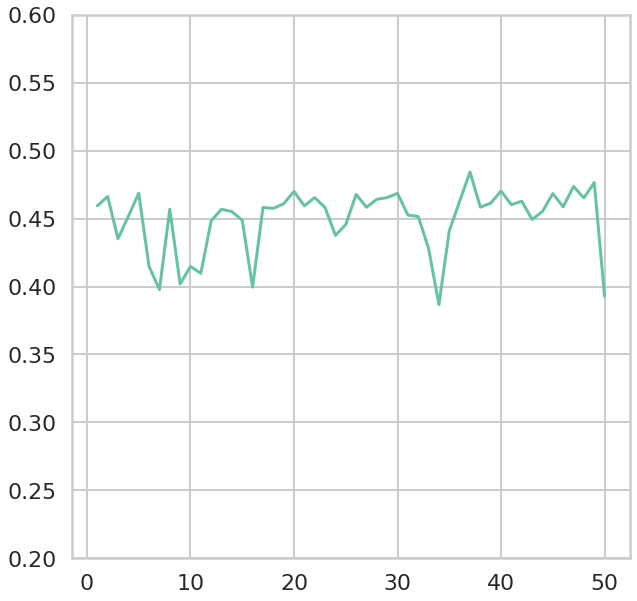

In [48]:
r2_list = [1-new_trials.trials[i]["result"]["loss"] for i in range(len(new_trials.trials))]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(x=list(range(1,len(new_trials.trials)+1)), y=r2_list, ax=ax)
ax.set_ylim(0.2,0.6)

In [49]:
rfe_list = [new_trials.trials[i]["result"]["rf_estimator"] for i in range(len(new_trials.trials))]
rfd_list = [new_trials.trials[i]["result"]["rf_depth"] for i in range(len(new_trials.trials))]
rff_list = [new_trials.trials[i]["result"]["rf_feature"] for i in range(len(new_trials.trials))]

In [50]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
36,167,245,228,0.484312
48,204,50,214,0.476548
46,200,98,221,0.473660
39,255,127,236,0.470279
19,118,187,114,0.469895
4,107,244,128,0.468646
29,99,204,83,0.468520
44,254,47,184,0.468381
25,215,171,139,0.467771
1,69,124,104,0.466284


In [51]:
!date

Wed Aug 11 00:47:18 UTC 2021
